In [1]:
from brian import *
from numpy.fft import rfft,irfft
from scipy.io import savemat
import numpy

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from brian.tools.datamanager import *
from brian.tools.taskfarm import *
from scipy import stats
from scipy import signal
from scipy.stats import mannwhitneyu
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
############################################################################################
#
#   Simulation code for "A computational model of Major Depression: The role of glutamate 
#     dysfunction on cingulo-frontal network dynamics" 
#     Ramirez-Mahaluf J.P., Roxin A., Mayberg H.S. and Compte A. Cerebral Cortex, 2015
#
############################################################################################


# This Python code requires the installation of Brian www.briansimulator.org

def find_rate(tdcs_current, report):
    

    NE=80                    # Excitatory neurons, for fast simulations in the article we use 80
    NI=20                     # Inhibitory neurons, for fast simulations in the article we use 20

    #Biophysical parameters
    tauav = 2*ms            # tau AMPA decay on vACC, this parameter was used to simulate MDD. Mild MDD (2.5%) = 2.05; Moderate MDD (5%) = 2.1; Severe MDD (7.5%) = 2.15
    tauad = 2*ms            # tau AMPA decay on dlPFC
    taun = 100*ms          # tau NMDA decay
    taux = 2*ms              # tau NMDA rise
    taug = 10*ms            # tau GABA decay
    Vt  =-50*mvolt           # spike threshold
    Vr  =-55*mvolt           # reset value
    Elv  =-70*mvolt         # resting potential ventral ACC, this parameter was used to simulate SSRI treatment.
    El  =-70*mvolt           # resting potential dlPFC
    Ven = 16.129*mV      
    refE= 2*ms		 # refractory periods piramidal cell
    refI= 1*ms                 # refractory period inhibitory cell
    cmE= 500*pF             #capacitance piramidal cel   
    cmI= 200*pF              #capacitance interneuron  
    tauE =20*ms              #tau piramidal cel
    tauI =10*ms               #tau interneuron 
    alpha =0.5*kHz
    S=1	#Connectivity sparsensess; S=1, all-to-all connectivity was used in the article; use S<1 for sparse random connectivity
    N=800/NE                  # Factor for rescaling the weights according tnpersego the number of neurons 

    tdcs_start_time = 0*ms
    tdcs_end_time = 60000*ms
    #tdcs_current = 6*pamp


    #Connection parameters
    wgEEN = 0.001761*(1/S)*N     #weight  excitatory to excitatory through NMDA
    wgEEA = 0.0009454*(1/S)*N    #weight  excitatory to excitatory through AMPA
    wgEIN = 0.0012*(1/S)*N         #weight  excitatory to inhibitory through NMDA
    wgEIA = 0.0004*(1/S)*N         #weight  excitatory to inhibitory through AMPA
    wgIEG = 0.005*(1/S)*N          #weight inhibitory to excitatory through GABA
    wgIIG = 0.004865*(1/S)*N     #weight inhibitory to  inhibitory through GABA
    wgEIA1 = 0.0004*(1/S)*N      #weight vACC excitatory to dlPFC inhibitory through NMDA
    wgEIA2 = 0.0004*(1/S)*N      #weight  dlPFC excitatory to vACC excitatory through NMDA


    #equations excitatory cell vACC 
    eqsE1 = '''
    dV/dt = (-gea*V-gen*V/(1+exp(-V/Ven)/3.57)-gi*(V+70*mV)-(V-Elv))/(tauE) + I/cmE   : volt
    dgea/dt = -gea/(tauav)           : 1
    dgi/dt = -gi/(taug)              : 1
    dspre/dt = -spre/(taun)+alpha*xpre*(1-spre) : 1
    dxpre/dt = -xpre/(taux)                     : 1
    gen: 1
    I: amp
    '''
    #equations inhibitory cell vACC 
    eqsI1 = '''
    dV/dt = (-gea*V-gen*V/(1+exp(-V/Ven)/3.57)-gi*(V+70*mV)-(V-El))/(tauI) + I/cmI   : volt
    dgea/dt = -gea/(tauav)           : 1
    dgi/dt = -gi/(taug)             : 1
    dspre/dt = -spre/(taun)+alpha*xpre*(1-spre) : 1
    dxpre/dt = -xpre/(taux)                     : 1
    gen: 1
    I: amp

    '''
    #equations excitatory cell dlPFC 
    eqsE2 = '''
    dV/dt = (-gea*V-gen*V/(1+exp(-V/Ven)/3.57)-gi*(V+70*mV)-(V-El))/(tauE) + I/cmE   : volt
    dgea/dt = -gea/(tauad)           : 1
    dgi/dt = -gi/(taug)             : 1
    dspre/dt = -spre/(taun)+alpha*xpre*(1-spre) : 1
    dxpre/dt = -xpre/(taux)                     : 1
    gen: 1
    I: amp

    '''
    #equations inhibitory cell dlPFC 
    eqsI2 = '''
    dV/dt = (-gea*V-gen*V/(1+exp(-V/Ven)/3.57)-gi*(V+70*mV)-(V-El))/(tauI) + I/cmI   : volt
    dgea/dt = -gea/(tauad)           : 1
    dgi/dt = -gi/(taug)             : 1
    dspre/dt = -spre/(taun)+alpha*xpre*(1-spre) : 1
    dxpre/dt = -xpre/(taux)                     : 1
    gen: 1
    I: amp
    '''
    #for i in range(5):

    #Populations of neurons: 
    Pev = NeuronGroup(NE, model= eqsE1, threshold=Vt, reset= Vr, refractory=refE)      #vACC excitatory neurons 
    Piv = NeuronGroup(NI, model= eqsI1, threshold=Vt, reset= Vr, refractory=refI)          #vACC inhibitory neurons

    Ped = NeuronGroup(NE, model= eqsE2, threshold=Vt, reset= Vr, refractory=refE)       #dlPFC excitatory neurons
    Pid = NeuronGroup(NI, model= eqsI2, threshold=Vt, reset= Vr, refractory=refI)          #dlPFC inhibitory neurons

    #Connection NMDA:
    selfnmda_v = IdentityConnection(Pev, Pev, 'xpre', weight=1.0) #NMDA connections, excitatory to excitatory neurons in vACC
    selfnmda_d = IdentityConnection(Ped, Ped, 'xpre', weight=1.0) #NMDA connections, excitatory to excitatory neurons in dlPF

    #Connections AMPA and GABA:
    Ceeav = Connection(Pev, Pev, 'gea', structure='dense') #AMPA connections, excitatory to excitatory neurons in vACC 
    Ceiav = Connection(Pev, Piv, 'gea', structure='dense') #AMPA connections, excitatory to inhibitory neurons in vACC
    Ciev = Connection(Piv, Pev, 'gi', structure='dense') # GABA connections, inhibitory to excitatory neurons in vACC
    Ciiv = Connection(Piv, Piv, 'gi', structure='dense') # GABA connections, excitatory to excitatory neurons in vACC

    Ceead = Connection(Ped, Ped, 'gea', structure='dense')#AMPA connections, excitatory to excitatory neurons in dlPFC 
    Ceiad = Connection(Ped, Pid, 'gea', structure='dense') #AMPA connections, excitatory to inhibitory neurons in dlPFC
    Cied = Connection(Pid, Ped, 'gi', structure='dense')# GABA connections, inhibitory to excitatory neurons in dlPFC
    Ciid = Connection(Pid, Pid, 'gi', structure='dense')# GABA connections, excitatory to excitatory neurons in dlPFC

    Ceiav1 = Connection(Pev, Pid, 'gea' )#AMPA connections, excitatory neurons in vACC target inhibitory neurons in dlPFC
    Ceiad1 = Connection(Ped, Piv, 'gea' )#AMPA connections excitatory neurons in dlPFC target inhibitory neurons in vACC

    Ceeav.connect_random(Pev, Pev, S, weight=wgEEA)  #AMPA connections, excitatory to excitatory neurons in vACC  
    Ceiav.connect_random(Pev, Piv, S, weight=wgEIA)  #AMPA connections, excitatory to inhibitory neurons in vACC
    Ciev.connect_random(Piv, Pev, S, weight=wgIEG)  # GABA connections, inhibitory to excitatory neurons in vACC
    Ciiv.connect_random(Piv, Piv, S, weight=wgIEG)  # GABA connections, excitatory to excitatory neurons in vACC

    Ceead.connect_random(Ped, Ped, S, weight=wgEEA) #AMPA connections, excitatory to excitatory neurons in dlPFC 
    Ceiad.connect_random(Ped, Pid, S, weight=wgEIA) #AMPA connections, excitatory to inhibitory neurons in dlPFC
    Cied.connect_random(Pid, Ped, S, weight=wgIEG) # GABA connections, inhibitory to excitatory neurons in dlPFC
    Ciid.connect_random(Pid, Pid, S,weight=wgIIG) # GABA connections, excitatory to excitatory neurons in dlPFC

    Ceiav1.connect_random(Pev, Pid, S, weight=wgEIA1) #AMPA connections, excitatory neurons in vACC target inhibitory neurons in dlPFC
    Ceiad1.connect_random(Ped, Piv, S, weight=wgEIA2) #AMPA connections excitatory neurons in dlPFC target inhibitory neurons in vACC


    #NMDA synapses
    E_nmda_v = asarray(Pev.spre)
    E_nmda_d = asarray(Ped.spre)
    E_gen_v = asarray(Pev.gen)
    E_gen_d = asarray(Ped.gen)
    I_gen_v = asarray(Piv.gen)
    I_gen_d = asarray(Pid.gen)

    #Calculate NMDA contributions
    @network_operation(when='start')
    def update_nmda():
        E_gen_v[:] = wgEEN/wgEEA * numpy.dot(E_nmda_v,Ceeav.W)
        I_gen_v[:] = wgEIN/wgEIA * numpy.dot(E_nmda_v,Ceiav.W)
        E_gen_d[:] = wgEEN/wgEEA * numpy.dot(E_nmda_d,Ceead.W)
        I_gen_d[:] = wgEIN/wgEIA * numpy.dot(E_nmda_d,Ceiad.W)

    @network_operation(when='start')
    def inject_current_gaba():
        if (defaultclock.t>tdcs_start_time)&(defaultclock.t <tdcs_end_time):
            
            Ped.I = tdcs_current
#             Pid.I = tdcs_current



    #External noise:
    extinput1E=PoissonGroup(NE,rates=1800*Hz)
    extinput1I=PoissonGroup(NI,rates=1800*Hz)

    input1_coE=IdentityConnection(extinput1E,Pev,'gea',weight=0.082708)
    input1_coI=IdentityConnection(extinput1I,Piv,'gea',weight=0.081)

    extinput2E=PoissonGroup(NE,rates=1800*Hz)
    extinput2I=PoissonGroup(NI,rates=1800*Hz)

    input2_coE=IdentityConnection(extinput2E,Ped,'gea',weight=0.082708)
    input2_coI=IdentityConnection(extinput2I,Pid,'gea',weight=0.081)
    extinput1E=PoissonGroup(NE,rates=1800*Hz)
    extinput1I=PoissonGroup(NI,rates=1800*Hz)

    input1_coE=IdentityConnection(extinput1E,Pev,'gea',weight=0.082708)
    input1_coI=IdentityConnection(extinput1I,Piv,'gea',weight=0.081)

    extinput2E=PoissonGroup(NE,rates=1800*Hz)
    extinput2I=PoissonGroup(NI,rates=1800*Hz)

    input2_coE=IdentityConnection(extinput2E,Ped,'gea',weight=0.082708)
    input2_coI=IdentityConnection(extinput2I,Pid,'gea',weight=0.081)


#     #Sadnnes task, emotional signal to vACC

    exttaskinput1_on=10000*ms
    exttaskinput1_off=10250*ms
    exttaskinput1E=PoissonGroup(80,rates=lambda t: (t>exttaskinput1_on)*(t<exttaskinput1_off)*200*Hz)

    taskinput1_coE=IdentityConnection(exttaskinput1E,Pev,'gea',weight=0.0955)

    exttaskinput2_on=15000*ms
    exttaskinput2_off=15250*ms
    exttaskinput2E=PoissonGroup(80,rates=lambda t: (t>exttaskinput2_on)*(t<exttaskinput2_off)*200*Hz)

    taskinput2_coE=IdentityConnection(exttaskinput2E,Pev,'gea',weight=0.0955)

    exttaskinput3_on=20000*ms
    exttaskinput3_off=20250*ms
    exttaskinput3E=PoissonGroup(80,rates=lambda t: (t>exttaskinput3_on)*(t<exttaskinput3_off)*200*Hz)

    taskinput3_coE=IdentityConnection(exttaskinput3E,Pev,'gea',weight=0.0955)

#     #Working memory task, cognitive signal to dlPFC
    exttaskinput4_on=25000*ms
    exttaskinput4_off=25250*ms
    exttaskinput4E=PoissonGroup(80,rates=lambda t: (t>exttaskinput4_on)*(t<exttaskinput4_off)*200*Hz)

    taskinput4_coE=IdentityConnection(exttaskinput4E,Ped,'gea',weight=0.0955)

    exttaskinput5_on=30000*ms
    exttaskinput5_off=30250*ms
    exttaskinput5E=PoissonGroup(80,rates=lambda t: (t>exttaskinput5_on)*(t<exttaskinput5_off)*200*Hz)

    taskinput5_coE=IdentityConnection(exttaskinput5E,Ped,'gea',weight=0.0955)

    exttaskinput6_on=35000*ms
    exttaskinput6_off=35250*ms
    exttaskinput6E=PoissonGroup(80,rates=lambda t: (t>exttaskinput6_on)*(t<exttaskinput6_off)*200*Hz)

    taskinput6_coE=IdentityConnection(exttaskinput6E,Ped,'gea',weight=0.0955)

    #Deep Brain Stimulation (DBS): 
    #extinput3I=SpikeGeneratorGroup(1,c_[zeros(2597),linspace(0*ms,19996.9*ms,2597)])
    #input3_coI=Connection(extinput3I,Piv,'gea',weight=0.03)


    #Save files
    #Miv = SpikeMonitor(Piv)
    #Mev = SpikeMonitor(Pev)
    #Mid = SpikeMonitor(Pid)
    #Med = SpikeMonitor(Ped)

#      Membrane_potential_monitor_v=StateMonitor(Pev,'V',record = True)
#     Membrane_potential_monitor_d=StateMonitor(Ped,'V',record = True)

    Mv=PopulationRateMonitor(Pev,bin=0.2*second)
    Md=PopulationRateMonitor(Ped,bin=0.2*second)
#     Mvi=PopulationRateMonitor(Piv,bin=0.2*second)
#     Mdi=PopulationRateMonitor(Pid,bin=0.2*second)
    #Mvm=PopulationRateMonitor(Pev,bin=1*second)
    #Mdm=PopulationRateMonitor(Ped,bin=1*second)


    #spikes_Ev = SpikeMonitor(Pev)
    #spikes_Ed = FileSpikeMonitor(Ped,'spikes_E_dlPFC.dat',record=True)
    #spikes_Iv = FileSpikeMonitor(Piv,'spikes_I_vACC.dat',record=True)
    #spikes_Id = FileSpikeMonitor(Pid,'spikes_I_dlPFC.dat',record=True)

    #run

    run(60*second)

    #Mean_potential_per_bin_0pA = []

    #Mean_potential_per_bin_0pA = Calc_mean_membran_potential_per_bin(Membrane_potential_monitor_e)

#     Md_potential=[]
    Md_rate_healthy_8pA = np.asarray(Md.rate)
    Mv_rate_healthy_8pA= np.asarray(Mv.rate)
    
#     Md_membrane_potential = Membrane_potential_monitor_d[:][:]


    del Md
    del Mv
#     del Membrane_potential_monitor_d
    return (tdcs_current,Md_rate_healthy_8pA,Mv_rate_healthy_8pA)

def start():
    N = 10
    dataman = DataManager('healthy_8pA_trial1')
    
#     current = [6*pamp, 0*pamp]
    current = [8*pamp,8*pamp,8*pamp,8*pamp,8*pamp,8*pamp,8*pamp,8*pamp,8*pamp,8*pamp]
    
    if dataman.itemcount()<N:
            M = N-dataman.itemcount()+1
            print("omg")
            run_tasks(dataman, find_rate, current)
    tdcs_current,Md_rate_healthy_8pA,Mv_rate_healthy_8pA = zip(*dataman.values())


    return(tdcs_current,Md_rate_healthy_8pA,Mv_rate_healthy_8pA)
    

    
    
tdcs_current,Md_rate_healthy_8pA,Mv_rate_healthy_8pA= start()
    
    
   

omg
Finished.


In [ ]:
dataman = DataManager('mild_ssri_part2_02ms_fs')
tdcs_current,Md_rate_mild_ssri_2_02fs,Mv_rate_mild_ssri_2_02fs = zip(*dataman.values())

In [ ]:
dataman = DataManager('mild_both_part1_02ms_fs')
tdcs_current,Md_rate_mild_both_1_02fs,Mv_rate_mild_both_1_02fs = zip(*dataman.values())


In [3]:
dataman = DataManager('mild_8pA_inh_part1_02ms_fs')
tdcs_current,Md_rate_mild_8pA_inh_1_02fs,Mv_rate_mild_8pA_inh_1_02fs = zip(*dataman.values())
# dataman = DataManager('mild_8pA_inh_part2_02ms_fs')
# tdcs_current,Md_rate_mild_8pA_inh_2_02fs,Mv_rate_mild_8pA_inh_2_02fs = zip(*dataman.values())
Md_total_rate_mild_8pA_inh_02ms_fs =np.vstack((Md_rate_mild_8pA_inh_1_02fs,Md_rate_mild_8pA_inh_2_02fs))
Mv_total_rate_mild_8pA_inh_02ms_fs = np.vstack((Mv_rate_mild_8pA_inh_1_02fs,Mv_rate_mild_8pA_inh_2_02fs))

In [2]:
dataman = DataManager('healthy_part1_02ms_fs')
tdcs_current,Md_rate_healthy_1_02fs,Mv_rate_healthy_1_02fs= zip(*dataman.values())
dataman = DataManager('healthy_part2_02ms_fs')
tdcs_current,Md_rate_healthy_2_02fs,Mv_rate_healthy_2_02fs= zip(*dataman.values())

Md_total_rate_healthy_prior_02ms_fs =np.vstack((Md_rate_healthy_1_02fs,Md_rate_healthy_2_02fs))
Mv_total_rate_healthy_prior_02ms_fs = np.vstack((Mv_rate_healthy_1_02fs,Mv_rate_healthy_2_02fs))

In [2]:
dataman = DataManager('Mild_8pA_part1_02ms_fs')
tdcs_current,Md_rate_mild_8pA_1_02fs,Mv_rate_mild_8pA_1_02fs= zip(*dataman.values())

dataman1 = DataManager('Mild_8pA_part2_02ms_fs')
tdcs_current,Md_rate_mild_8pA_2_02fs,Mv_rate_mild_8pA_2_02fs= zip(*dataman1.values())

Md_total_rate_mild_8pA_02ms_fs =np.vstack((Md_rate_mild_8pA_1_02fs,Md_rate_mild_8pA_2_02fs))
Mv_total_rate_mild_8pA_02ms_fs = np.vstack((Mv_rate_mild_8pA_1_02fs,Mv_rate_mild_8pA_2_02fs))

In [3]:
dataman1 = DataManager('Mild_s095_part1_02ms_fs')
tdcs_current,Md_rate_mild_s095_1_02ms_fs,Mv_rate_mild_s095_1_02ms_fs= zip(*dataman1.values())
dataman2 = DataManager('Mild_s095_part2_02ms_fs')
tdcs_current,Md_rate_mild_s095_2_02ms_fs,Mv_rate_mild_s095_2_02ms_fs= zip(*dataman2.values())

Md_total_rate_mild_s095_02ms_fs =np.vstack((Md_rate_mild_s095_1_02ms_fs,Md_rate_mild_s095_2_02ms_fs))
Mv_total_rate_mild_s095_02ms_fs = np.vstack((Mv_rate_mild_s095_1_02ms_fs,Mv_rate_mild_s095_2_02ms_fs))

In [4]:
dataman1 = DataManager('Mild_prior_part1_02ms_fs')
tdcs_current,Md_rate_mild_prior_1_02fs,Mv_rate_mild_prior_1_02fs= zip(*dataman1.values())

dataman2 = DataManager('Mild_prior_part2_02ms_fs')
tdcs_current,Md_rate_mild_prior_2_02fs,Mv_rate_mild_prior_2_02fs= zip(*dataman2.values())

Md_total_rate_mild_prior_02fs = np.vstack((Md_rate_mild_prior_2_02fs,Md_rate_mild_prior_1_02fs))
Mv_total_rate_mild_prior_02fs = np.vstack((Mv_rate_mild_prior_2_02fs,Mv_rate_mild_prior_1_02fs))

In [2]:
# dataman = DataManager('healthy_0to9_20seconds_trial2')
# tdcs_current,Md_rate_healthy_varied_currents,Md_membrane_potential = zip(*dataman.values())
dataman2 = DataManager('Healthy_membrane_1to10')
current,Md_rate,Md_membrane_monitor_healthy= zip(*dataman2.values())


In [2]:
dataman2 = DataManager('Mild_s095_part1')
tdcs_current,Md_rate_mild_s0951,Mv_rate_mild_s0951= zip(*dataman2.values())
dataman = DataManager('mild_s095_trial2')
tdcs_current,Md_rate_mild_s0952,Mv_rate_mild_s0952 = zip(*dataman.values())

Md_rate_mild_s095 = np.vstack((Md_rate_mild_s0951,Md_rate_mild_s0952))
Mv_rate_mild_s095= np.vstack((Mv_rate_mild_s0951,Mv_rate_mild_s0952))

In [42]:
Md_mean_rate_healthy_prior_02ms_fs = np.mean(Md_total_rate_healthy_prior_02ms_fs, axis = 0)
Mv_mean_rate_healthy_prior_02ms_fs = np.mean(Mv_total_rate_healthy_prior_02ms_fs, axis = 0)

Md_mean_rate_mild_s095_02ms_fs = np.mean(Md_total_rate_mild_s095_02ms_fs, axis = 0)
Mv_mean_rate_mild_s095_02ms_fs = np.mean(Mv_total_rate_mild_s095_02ms_fs, axis = 0)

Md_mean_rate_mild_8pA_02ms_fs = np.mean(Md_total_rate_mild_8pA_02ms_fs, axis = 0)
Mv_mean_rate_mild_8pA_02ms_fs = np.mean(Mv_total_Md_total_rate_mild_prior_02fsrate_mild_8pA_02ms_fs, axis = 0)

Md_mean_rate_mild_prior_02fs = np.mean(Md_total_rate_mild_prior_02fs, axis = 0)
Mv_mean_rate_mild_prior_02fs = np.mean(Mv_total_rate_mild_prior_02fs, axis = 0)

[[ 6.71012270e-01  8.50268405e+01]
 [ 9.52938671e+00 -4.51194637e-13]]
0.7866529017156096


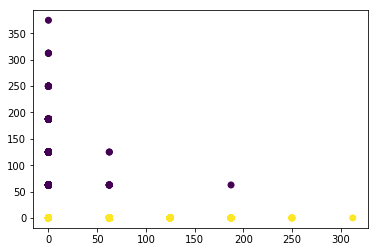

In [43]:
clustering(Md_total_rate_mild_s095_02ms_fs,Mv_total_rate_mild_s095_02ms_fs)

[[ 0.55995865 85.93211578]
 [14.60485821  0.        ]]
0.7285978197296888


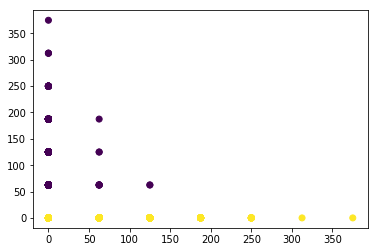

In [42]:
clustering(Md_total_rate_mild_8pA_02ms_fs,Mv_total_rate_mild_8pA_02ms_fs)

[[ 0.29024768 86.20356037]
 [ 5.80129567  0.        ]]
0.8325708569404701


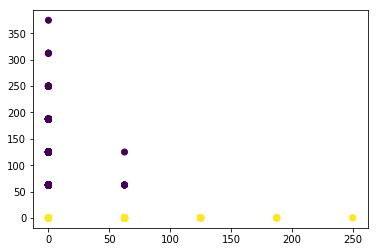

In [41]:
clustering(Md_total_rate_mild_prior_02fs,Mv_total_rate_mild_prior_02fs)

[[ 7.81250000e+01  2.57571742e-14]
 [-1.16351373e-13  4.52082816e-13]
 [ 4.08496732e-01  6.25000000e+01]
 [-6.21724894e-15  1.42094017e+02]]
0.9778194898137411


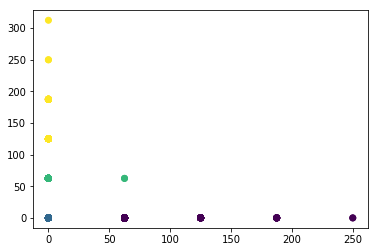

In [10]:
clustering(Md_total_rate_healthy_prior_02ms_fs,Mv_total_rate_healthy_prior_02ms_fs)

In [9]:
def clustering(Md_total_rate,Mv_total_rate):
    N = np.zeros(20)

    Md_total_rate[:,0] = N
    Mv_total_rate[:,0] = N
    Md_total_rate_re, Mv_total_rate_re = reduce_sampling(Md_total_rate, Mv_total_rate)
    Data = np.stack((Md_total_rate_re.flatten(), Mv_total_rate_re.flatten()), axis = -1)
    kmeans = KMeans(n_clusters=4).fit(Data)
    centroids = kmeans.cluster_centers_
    
    print(centroids)
#     plt.figure(figsize=(15, 10))
    plt.scatter(Data[:,0], Data[:,1], c= kmeans.labels_.astype(float))
#     plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
    print(silhouette_score(Data, kmeans.labels_))
    
    

<function matplotlib.pyplot.legend>

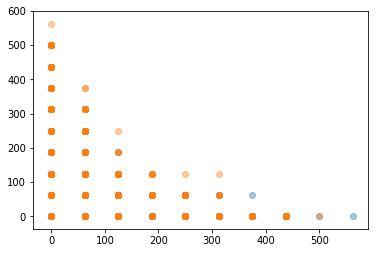

In [45]:
Md_mean_rate_healthy_prior_02ms_fs = np.mean(Md_total_rate_healthy_prior_02ms_fs, axis = 0)
Mv_mean_rate_healthy_prior_02ms_fs = np.mean(Mv_total_rate_healthy_prior_02ms_fs, axis = 0)

plt.scatter(Md_total_rate_healthy_prior_02ms_fs.flatten(),Mv_total_rate_healthy_prior_02ms_fs.flatten(), label = 'healthy', alpha = 0.4)
plt.scatter(Md_total_rate_mild_prior_02fs.flatten(),Mv_total_rate_mild_prior_02fs.flatten(), label = 'prior', alpha = 0.4)
plt.legend

0.4450362408369136


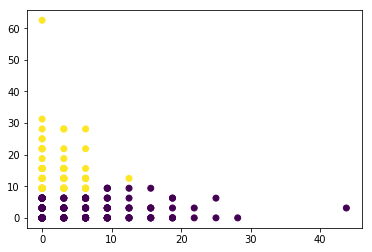

In [14]:
Md_total_rate_re, Mv_total_rate_re = reduce_sampling(Md_total_rate_healthy_prior_02ms_fs, Mv_total_rate_healthy_prior_02ms_fs)
Md_mean_rate_re = np.mean(Md_total_rate_re, axis = 0)
Mv_mean_rate_re = np.mean(Mv_total_rate_re, axis = 0)


Data = np.stack((Md_mean_rate_re, Mv_mean_rate_re), axis = -1)
kmeans = KMeans(n_clusters=2).fit(Data)
plt.scatter(Data[:,0], Data[:,1], c= kmeans.labels_.astype(float))
print(silhouette_score(Data, kmeans.labels_))

0.3677171699131613


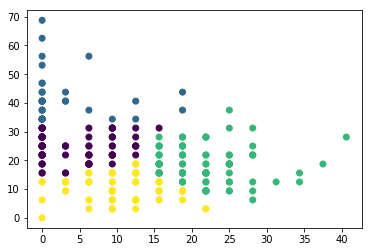

In [7]:

N = np.zeros(20)
Md_total_rate_mild_8pA_02ms_fs[:,0] = N
Mv_total_rate_mild_8pA_02ms_fs[:,0] = N
Md_total_rate_re, Mv_total_rate_re = reduce_sampling(Md_total_rate_mild_8pA_02ms_fs,Mv_total_rate_mild_8pA_02ms_fs)
Md_mean_rate_re = np.mean(Md_total_rate_re, axis = 0)
Mv_mean_rate_re = np.mean(Mv_total_rate_re, axis = 0)


Data = np.stack((Md_mean_rate_re, Mv_mean_rate_re), axis = -1)
kmeans = KMeans(n_clusters=4).fit(Data)
plt.scatter(Data[:,0], Data[:,1], c= kmeans.labels_.astype(float))
print(silhouette_score(Data, kmeans.labels_))

0.4967044127416716


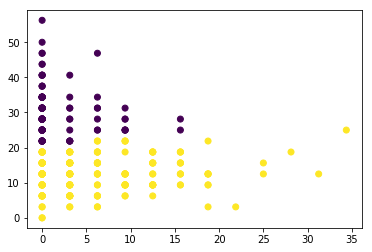

In [19]:
epoch
N = np.zeros(20)
Md_total_rate_mild_prior_02fs[:,0] = N
Mv_total_rate_mild_prior_02fs[:,0] = N
Md_total_rate_re, Mv_total_rate_re = reduce_sampling(Md_total_rate_mild_prior_02fs,Mv_total_rate_mild_prior_02fs)
Md_mean_rate_re = np.mean(Md_total_rate_re, axis = 0)
Mv_mean_rate_re = np.mean(Mv_total_rate_re, axis = 0)


Data = np.stack((Md_mean_rate_re, Mv_mean_rate_re), axis = -1)
kmeans = KMeans(n_clusters=2).fit(Data)
plt.scatter(Data[:,0], Data[:,1], c= kmeans.labels_.astype(float))
print(silhouette_score(Data, kmeans.labels_))

In [58]:

Mv_8pA_to_cognitive_mean_red = []
Mv_prior_to_cognitive_mean_red = []
Mv_s095_to_cognitive_mean_red = []
Mv_healthy_to_cognitive_mean_red = []


Md_8pA_baseline_mean,Mv_8pA_baseline_mean,Md_8pA_to_cognitive_mean,Mv_8pA_to_cognitive_mean,Md_8pA_to_emotional_mean,Mv_8pA_to_emotional_mean,Md_8pA_rest_mean,Mv_8pA_rest_mean = divide_epochs(Md_total_rate_mild_8pA_02ms_fs, Mv_total_rate_mild_8pA_02ms_fs)
Md_prior_baseline_mean,Mv_prior_baseline_mean,Md_prior_to_cognitive_mean,Mv_prior_to_cognitive_mean,Md_prior_to_emotional_mean,Mv_prior_to_emotional_mean,Md_prior_rest_mean,Mv_prior_rest_mean = divide_epochs(Md_total_rate_mild_prior_02fs, Mv_total_rate_mild_prior_02fs)
Md_s095_baseline_mean,Mv_s095_baseline_mean,Md_s095_to_cognitive_mean,Mv_s095_to_cognitive_mean,Md_s095_to_emotional_mean,Mv_s095_to_emotional_mean,Md_s095_rest_mean,Mv_s095_rest_mean = divide_epochs(Md_total_rate_mild_s095_02ms_fs, Mv_total_rate_mild_s095_02ms_fs)
Md_healthy_baseline_mean,Mv_healthy_baseline_mean,Md_healthy_to_cognitive_mean,Mv_healthy_to_cognitive_mean,Md_healthy_to_emotional_mean,Mv_healthy_to_emotional_mean,Md_healthy_rest_mean,Mv_healthy_rest_mean = divide_epochs( Md_total_rate_healthy_prior_02ms_fs,Mv_total_rate_healthy_prior_02ms_fs)



step = np.arange(0,len(Md_8pA_to_cognitive_mean),1000)
for i in step:
    Mv_8pA_to_cognitive_mean_red.append(Mv_8pA_to_cognitive_mean[i])
    Mv_prior_to_cognitive_mean_red.append(Mv_prior_to_cognitive_mean[i])
    Mv_s095_to_cognitive_mean_red.append(Mv_s095_to_cognitive_mean[i])
    Mv_healthy_to_cognitive_mean_red.append(Mv_healthy_to_cognitive_mean[i])
    
    
Mv_8pA_to_cognitive_mean_red = np.asarray(Mv_8pA_to_cognitive_mean_red)
Mv_prior_cognitive_mean_red = np.asarray(Mv_prior_to_cognitive_mean_red)
Mv_s095_to_cognitive_mean_red = np.asarray(Mv_s095_to_cognitive_mean_red)
Mv_healthy_to_cognitive_mean_red = np.asarray(Mv_healthy_to_cognitive_mean_red)




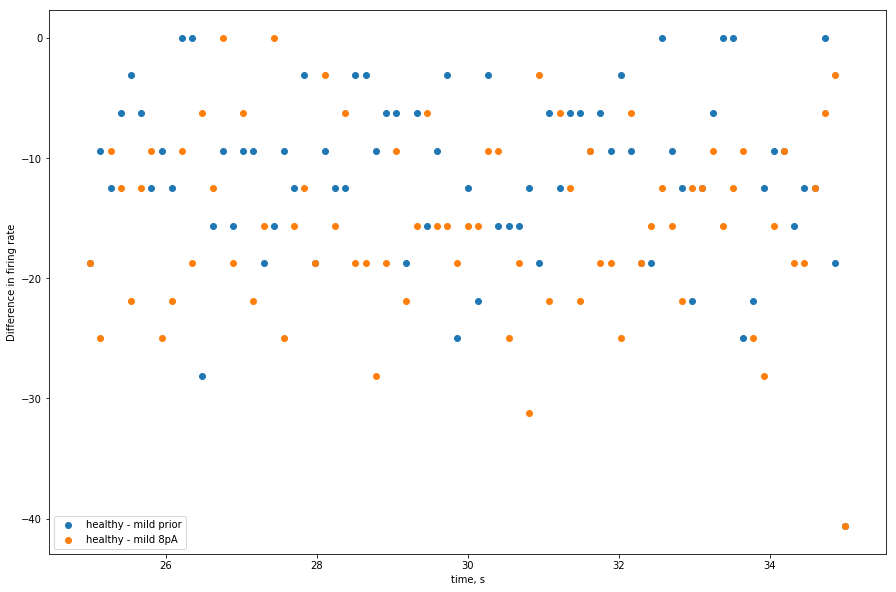

In [61]:
epochtime = np.linspace(25,35, num = len(Mv_prior_to_cognitive_mean_red))

plt.figure(figsize=(15, 10))
# plt.plot(time,Mv_healthy_to_cognitive_mean_red - Mv_s095_to_cognitive_mean_red,label = 'healthy - mild s = 0.95')
plt.scatter(time,Mv_healthy_to_cognitive_mean_red - Mv_prior_to_cognitive_mean_red, label = 'healthy - mild prior')
plt.scatter(time,Mv_healthy_to_cognitive_mean_red - Mv_8pA_to_cognitive_mean_red, label = 'healthy - mild 8pA')
# plt.plot(time,Md_healthy_to_cognitive_mean_red, label = 'healthy')
plt.xlabel('time, s')
plt.ylabel('Difference in firing rate')

plt.legend()
plt.savefig('Mv Difference in firing rate in cognitive epoch 8pA')

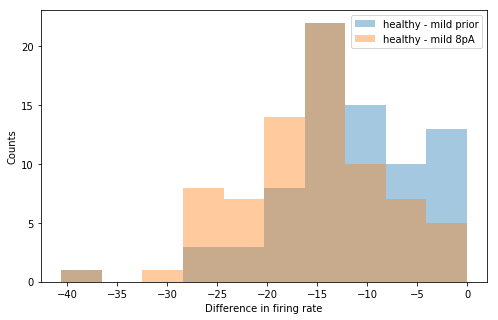

In [79]:
plt.figure(figsize=(8, 5))
plt.hist(Mv_healthy_to_cognitive_mean_red - Mv_prior_to_cognitive_mean_red, alpha = 0.4,label = 'healthy - mild prior')
plt.hist(Mv_healthy_to_cognitive_mean_red - Mv_8pA_to_cognitive_mean_red, alpha = 0.4,label = 'healthy - mild 8pA')
plt.legend()
plt.xlabel('Difference in firing rate')
plt.ylabel('Counts')
plt.savefig('Mv histogram of Differences in firing rate in cognitive epoch 8pA')

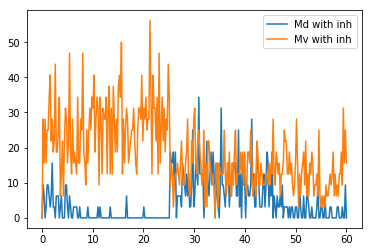

In [7]:
Md_total_rate_mild_prior_02fs_red,Mv_total_rate_mild_prior_02fs_red = reduce_sampling(Md_total_rate_mild_prior_02fs,Mv_total_rate_mild_prior_02fs)

Md_mean_rate_mild_prior_02fs_red= np.mean(Md_total_rate_mild_prior_02fs_red, axis = 0)
Mv_mean_rate_mild_prior_02fs_red = np.mean(Mv_total_rate_mild_prior_02fs_red, axis = 0)

Md_mean_rate_mild_prior_02fs_red = np.insert(np.delete(Md_mean_rate_mild_prior_02fs_red,0),0,0)
Mv_mean_rate_mild_prior_02fs_red = np.insert(np.delete(Mv_mean_rate_mild_prior_02fs_red,0),0,0)


time = np.linspace(0,60, 300)
plt.plot(time, Md_mean_rate_mild_prior_02fs_red, label = 'Md with inh')
plt.plot(time, Mv_mean_rate_mild_prior_02fs_red,label = 'Mv with inh' )


plt.legend()


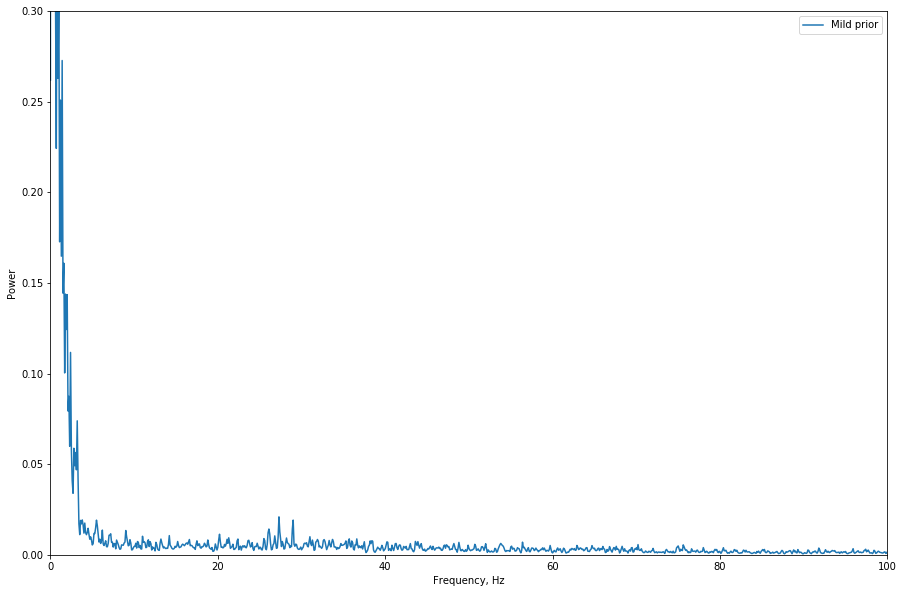

In [49]:
Md_mean_rate_mild_prior_02fs = np.mean(Md_total_rate_mild_prior_02fs, axis = 0)
Md_mean_rate_healthy_prior_02ms_fs = np.mean(Md_total_rate_healthy_prior_02ms_fs, axis = 0)
Md_mean_rate_mild_8pA_02ms_fs = np.mean(Md_total_rate_mild_8pA_02ms_fs, axis = 0)

Md_mean_rate_mild_prior_02fs = np.insert(np.delete(Md_mean_rate_mild_prior_02fs,0),0,0)
Md_mean_rate_healthy_prior_02ms_fs = np.insert(np.delete(Md_mean_rate_healthy_prior_02ms_fs,0),0,0)
Md_mean_rate_mild_8pA_02ms_fs = np.insert(np.delete(Md_mean_rate_mild_8pA_02ms_fs,0),0,0)


Md_mean_rate_mild_s095_02fs = np.mean(Md_total_rate_mild_s095_02ms_fs, axis = 0)
Md_mean_rate_mild_s095_02fs = np.insert(np.delete(Md_mean_rate_mild_s095_02fs,0),0,0)

f_p,Pxx_den_p = signal.welch(Md_mean_rate_mild_prior_02fs, 5000, nperseg=50000,scaling='spectrum',noverlap = 40000)
f_h,Pxx_den_h = signal.welch(Md_mean_rate_healthy_prior_02ms_fs, 5000, nperseg=50000,scaling='spectrum',noverlap = 40000)
f_t,Pxx_den_t = signal.welch(Md_mean_rate_mild_8pA_02ms_fs, 5000, nperseg=50000,scaling='spectrum',noverlap = 40000)
f_s,Pxx_den_s = signal.welch(Md_mean_rate_mild_s095_02fs, 5000, nperseg=50000,scaling='spectrum',noverlap = 40000)


plt.figure(figsize=(15, 10))
plt.xlim(0,100)
plt.ylim(0,0.3)
plt.plot(f_p,Pxx_den_p, label = 'Mild prior')
# plt.plot(f_h,Pxx_den_h, label = ' Healthy prior')
# plt.plot(f_s,Pxx_den_s, label = ' GABA decreased')
plt.ylabel('Power')
plt.xlabel('Frequency, Hz')
plt.legend()

# plt.savefig('Md GABA healthy mild conditions overall frequency comparison')

In [34]:
significance_test(Md_total_rate_mild_8pA_02ms_fs,Mv_total_rate_mild_8pA_02ms_fs, Md_total_rate_mild_8pA_inh_02ms_fs, Mv_total_rate_mild_8pA_inh_02ms_fs, 4)

Statistics=1927938072502.000, p=0.000
Different distribution for dlPFC rest (reject H0)
Statistics=1994010343001.500, p=0.000
Different distribution for vACC rest(reject H0)


In [5]:
def reduce_sampling(Md_rate, Mv_rate):
    
    step = np.arange(0,300000,1000)
    Md_reduced = []
    Mv_reduced = []
    for j in range(20):

        for i in step: 
            Md_reduced.append(Md_rate[j][i])


    Md_reduced = np.vstack(np.split(np.asarray(Md_reduced),20))

    for j in range(20):

        for i in step: 
            Mv_reduced.append(Mv_rate[j][i])


    Mv_reduced = np.vstack(np.split(np.asarray(Mv_reduced),20))
    Md_reduced = np.vstack(np.split(np.asarray(Md_reduced),20))
    return(Md_reduced, Mv_reduced)

def extract_frequencies(firing_rate, mean, frequency):
    
    if frequency == 'beta':
        lower = 12
        upper  = 30
    if frequency == 'alpha':
        lower = 7
        upper = 14
    if frequency == 'theta':
        lower = 4
        upper = 8
    
    f = []
    Pxx_den = []
    power = []
    frequencies = []
    
    if mean == True:
        f,Pxx_den = signal.welch(firing_rate, 5000, nperseg=50000,scaling='spectrum',noverlap = 25000)
        
        f = np.asarray(f)
        Pxx_den = np.asarray(Pxx_den)
        
        for i in range(len(f)):

            if (f[i]>=lower) and (f[i]<=upper):
                power.append(Pxx_den[i])
                frequencies.append(f[i])
    else:
        
        for i in range(20):
            a,b = signal.welch(firing_rate[i], 5000, nperseg=50000,scaling='spectrum',noverlap = 25000)
            f.append(a)
            Pxx_den.append(b)
        f = np.asarray(f)
        Pxx_den = (np.asarray(Pxx_den))



        for j in range(20):

            for i in range(len(f)):

                if (f[j][i]>lower) and (f[j][i]<upper):
                    power.append(Pxx_den[j][i])
                    frequencies.append(f[j][i])
                    
    return(power, frequencies)

In [10]:
Mv_mean_rate_mild_8pA_02ms_fs = np.mean(Mv_total_rate_mild_8pA_02ms_fs, axis = 0)
Mv_mean_rate_mild_prior_02ms_fs = np.mean(Mv_total_rate_mild_prior_02fs, axis = 0)
Md_mean_rate_mild_8pA_02ms_fs = np.mean(Md_total_rate_mild_8pA_02ms_fs, axis = 0)
Md_mean_rate_mild_prior_02ms_fs = np.mean(Md_total_rate_mild_prior_02fs, axis = 0)
# significance_test_frequencies(Mv_mean_rate_mild_8pA_02ms_fs,Mv_mean_rate_mild_prior_02ms_fs, 'vACC total 8pA vs prior', True)

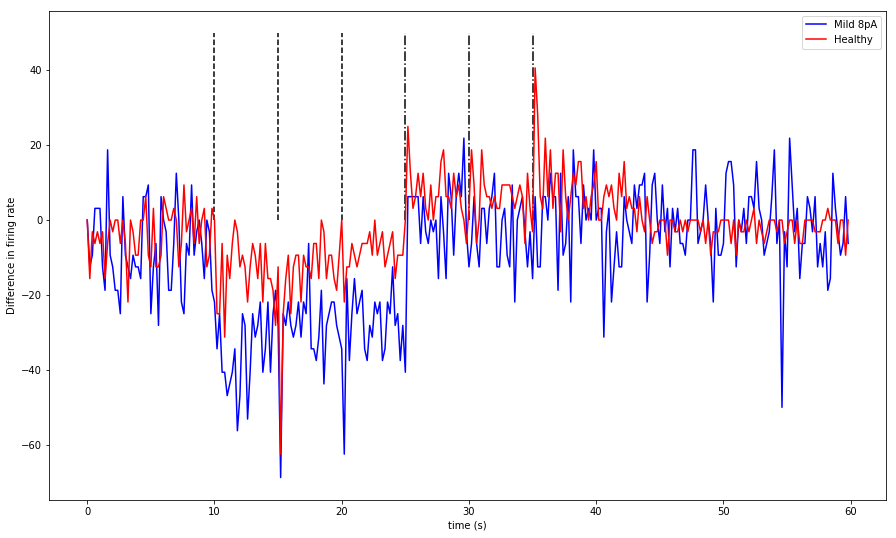

In [70]:
plot_trace(Md_total_rate_mild_8pA_02ms_fs, Mv_total_rate_mild_8pA_02ms_fs,Md_total_rate_healthy_prior_02ms_fs, Mv_total_rate_healthy_prior_02ms_fs, True, 'Mild 8pA', 'Healthy','Mild vs healthy difference')

In [67]:
significance_test_frequencies(Md_healthy_to_cognitive_mean,Md_prior_to_cognitive_mean, 'dlPFC healthy vs mild prior', True)

Statistics=1965.000, p=0.003
('Different distribution for (reject H0)', 'dlPFC healthy vs mild prior')


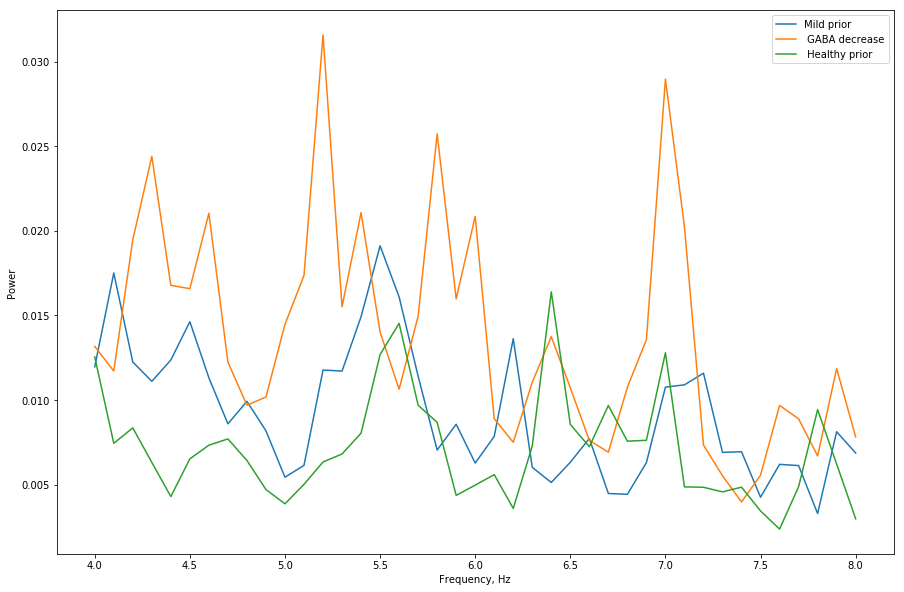

In [87]:

plot_time_frequency(Md_mean_rate_healthy_prior_02ms_fs,Md_mean_rate_mild_s095_02ms_fs, Md_mean_rate_mild_prior_02fs, 'Md  theta frequency comparison health mild and GABA ', True,'theta')

Text(0.5,0,'Time [sec]')

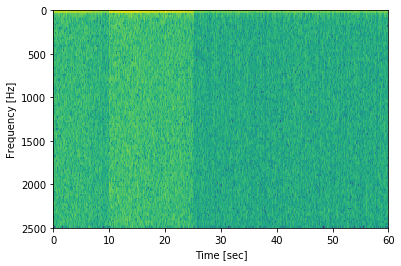

In [19]:

plt.specgram(Mv_mean_rate_healthy_prior_02ms_fs, Fs = 5000)
plt.ylabel('Frequency [Hz]')

plt.xlabel('Time [sec]')


In [85]:
def plot_time_frequency (condition_s, condition_t, condition_p, name, mean, frequency):

    if mean: 
        
        beta_power_t,beta_frequencies_t = extract_frequencies(condition_t,mean,frequency)
        beta_power_p,beta_frequencies_p = extract_frequencies(condition_p,mean,frequency)
        beta_power_s,beta_frequencies_s = extract_frequencies(condition_s,mean,frequency)

    plt.figure(figsize=(15, 10))
    plt.plot(beta_frequencies_p, beta_power_p, label = 'Mild prior')
    plt.plot(beta_frequencies_t, beta_power_t, label = ' GABA decrease')
    plt.plot(beta_frequencies_s, beta_power_s, label = ' Healthy prior')
    plt.ylabel('Power')
    plt.xlabel('Frequency, Hz')
    plt.legend()
    
#     plt.title(name)

#     print('Total beta power mild prior',sum(beta_power_p))
#     print('Total beta power healthy prior',sum(beta_power_s))
#     print('Total beta power mild tdCS',sum(beta_power_t))

    # plt.show()
    plt.savefig(name)

In [40]:
significance_total_firing_rate(Md_total_rate_mild_8pA_02ms_fs,Mv_total_rate_mild_8pA_02ms_fs,Md_total_rate_mild_s095_02ms_fs,Mv_total_rate_mild_s095_02ms_fs)

Statistics=17436351301138.500, p=0.000
Different distribution for dlPFC rate total (reject H0)
Statistics=17471991163471.000, p=0.000
Different distribution for vACC rate total (reject H0)


In [36]:
significance_total_power(Md_total_rate_mild_8pA_02ms_fs,Mv_total_rate_mild_8pA_02ms_fs,Md_total_rate_mild_s095_02ms_fs,Mv_total_rate_mild_s095_02ms_fs, 'beta')

Statistics=13250.000, p=0.001
Different distribution for dlPFC power total (reject H0)
Statistics=13900.000, p=0.006
Different distribution for vACC power total (reject H0)


In [37]:
def significance_total_power(Md_1,Mv_1,Md_2,Mv_2, frequency):
    
    Md1_mean_rate = np.mean(Md_1, axis = 0)
    Mv1_mean_rate = np.mean(Mv_1, axis = 0)
    
    Md2_mean_rate = np.mean(Md_2, axis = 0)
    Mv2_mean_rate = np.mean(Mv_2, axis = 0)
    
    Md1_mean_power,Md1_mean_frequencies = extract_frequencies(Md1_mean_rate,True, frequency)
    Mv1_mean_power,Mv1_mean_frequencies = extract_frequencies(Mv1_mean_rate,True, frequency)
    Md1_mean_power = np.asarray(Md1_mean_power)
    Mv1_mean_power = np.asarray(Mv1_mean_power)

    Md2_mean_power,Md2_mean_frequencies = extract_frequencies(Md2_mean_rate,True, frequency)
    Mv2_mean_power,Mv2_mean_frequencies = extract_frequencies(Mv2_mean_rate,True, frequency)
    Md2_mean_power = np.asarray(Md2_mean_power)
    Mv2_mean_power = np.asarray(Mv2_mean_power)


    stat, p = mannwhitneyu(Md1_mean_power.flatten(), Md2_mean_power.flatten())
    print('Statistics=%.3f, p=%.3f' % (stat, p))
            # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution for dlPFC power total(fail to reject H0)')
    else:
        print('Different distribution for dlPFC power total (reject H0)')
        
    stat, p = mannwhitneyu(Mv1_mean_power.flatten(), Mv2_mean_power.flatten())
    print('Statistics=%.3f, p=%.3f' % (stat, p))
            # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution for vACC power total(fail to reject H0)')
    else:
        print('Different distribution for vACC power total (reject H0)')

def significance_total_firing_rate(Md_1,Mv_1,Md_2,Mv_2):
    
    
    
    stat, p = mannwhitneyu(Md_1.flatten(), Md_2.flatten())
    print('Statistics=%.3f, p=%.3f' % (stat, p))
            # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution for dlPFC rate total(fail to reject H0)')
    else:
        print('Different distribution for dlPFC rate total (reject H0)')
        
    stat, p = mannwhitneyu(Mv_1.flatten(), Mv_2.flatten())
    print('Statistics=%.3f, p=%.3f' % (stat, p))
            # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution for vACC rate total(fail to reject H0)')
    else:
        print('Different distribution for vACC rate total (reject H0)')


# significance_test_frequencies(Md_total_rate_mild_8pA_02ms_fs,Mv_total_rate_mild_8pA_02ms_fs,Md_total_rate_mild_s095_02ms_fs,Mv_total_rate_mild_s095_02ms_fs, 'sgsf', True, 'alpha',4)

In [21]:
significance_test_frequencies(Md_total_rate_mild_s095_02ms_fs,Mv_total_rate_mild_s095_02ms_fs,Md_total_rate_mild_8pA_02ms_fs,Mv_total_rate_mild_8pA_02ms_fs, True, 'ahd','theta',4)

Statistics=748.000, p=0.197
Same distribution for dlPFC rest(fail to reject H0)
Statistics=665.000, p=0.052
Same distribution for vACC rest(fail to reject H0)


In [6]:
# Mann-Whitney U Test
def significance_test_frequencies(Md_1,Mv_1,Md_2,Mv_2, mean, name,frequency,epoch):

    Md_1_baseline_mean,Mv_1_baseline_mean,Md_1_to_cognitive_mean,Mv_1_to_cognitive_mean,Md_1_to_emotional_mean,Mv_1_to_emotional_mean,Md_1_rest_mean,Mv_1_rest_mean = divide_epochs( Md_1,Mv_1)
    Md_2_baseline_mean,Mv_2_baseline_mean,Md_2_to_cognitive_mean,Mv_2_to_cognitive_mean,Md_2_to_emotional_mean,Mv_2_to_emotional_mean,Md_2_rest_mean,Mv_2_rest_mean = divide_epochs( Md_2,Mv_2)

    Md_1_baseline_mean_power,Md_1_baseline_mean_frequencies = extract_frequencies(Md_1_baseline_mean,mean, frequency)
    Mv_1_baseline_mean_power,Mv_1_baseline_mean_frequencies = extract_frequencies(Mv_1_baseline_mean,mean, frequency)
    Md_1_baseline_mean_power = np.asarray(Md_1_baseline_mean_power)
    Mv_1_baseline_mean_power = np.asarray(Mv_1_baseline_mean_power)
    
    
    Md_1_to_cognitive_mean_power,Md_1_to_cognitive_mean_frequencies = extract_frequencies(Md_1_to_cognitive_mean,mean, frequency)
    Mv_1_to_cognitive_mean_power,Mv_1_to_cognitive_mean_frequencies= extract_frequencies(Mv_1_to_cognitive_mean,mean, frequency)
    Md_1_to_cognitive_mean_power = np.asarray(Md_1_to_cognitive_mean_power)
    Mv_1_to_cognitive_mean_power = np.asarray(Mv_1_to_cognitive_mean_power)
    
    Md_1_to_emotional_mean_power,Md_1_to_emotional_mean_frequencies = extract_frequencies(Md_1_to_emotional_mean,mean, frequency)
    Mv_1_to_emotional_mean_power,Mv_1_to_emotional_mean_frequencies = extract_frequencies(Mv_1_to_emotional_mean,mean, frequency)
    Md_1_to_emotional_mean_power = np.asarray(Md_1_to_emotional_mean_power)
    Mv_1_to_emotional_mean_power = np.asarray(Mv_1_to_emotional_mean_power)
    
    Md_1_rest_mean_power,Md_1_rest_mean_frequencies = extract_frequencies(Md_1_rest_mean,mean, frequency)
    Mv_1_rest_mean_power,Mv_1_rest_mean_frequencies = extract_frequencies(Mv_1_rest_mean,mean, frequency)
    Md_1_rest_mean_power = np.asarray(Md_1_rest_mean_power)
    Mv_1_rest_mean_power = np.asarray(Mv_1_rest_mean_power)
    

    Md_2_baseline_mean_power,Md_2_baseline_mean_frequencies = extract_frequencies(Md_2_baseline_mean,mean, frequency)
    Mv_2_baseline_mean_power,Mv_2_baseline_mean_frequencies = extract_frequencies(Mv_2_baseline_mean,mean, frequency)
    
    Md_2_baseline_mean_power = np.asarray(Md_2_baseline_mean_power)
    Mv_2_baseline_mean_power = np.asarray(Mv_2_baseline_mean_power)
    
    Md_2_to_cognitive_mean_power,Md_2_to_cognitive_mean_frequencies = extract_frequencies(Md_2_to_cognitive_mean,mean, frequency)
    Mv_2_to_cognitive_mean_power,Mv_2_to_cognitive_mean_frequencies= extract_frequencies(Mv_2_to_cognitive_mean,mean, frequency)
    Md_2_to_cognitive_mean_power = np.asarray(Md_2_to_cognitive_mean_power)
    Mv_2_to_cognitive_mean_power = np.asarray(Mv_2_to_cognitive_mean_power)
    
    
    
    Md_2_to_emotional_mean_power,Md_2_to_emotional_mean_frequencies = extract_frequencies(Md_2_to_emotional_mean,mean, frequency)
    Mv_2_to_emotional_mean_power,Mv_2_to_emotional_mean_frequencies = extract_frequencies(Mv_2_to_emotional_mean,mean, frequency)
    Md_2_to_emotional_mean_power = np.asarray(Md_2_to_emotional_mean_power)
    Mv_2_to_emotional_mean_power = np.asarray(Mv_2_to_emotional_mean_power)
    
    
    
    Md_2_rest_mean_power,Md_2_rest_mean_frequencies = extract_frequencies(Md_2_rest_mean,mean, frequency)
    Mv_2_rest_mean_power,Mv_2_rest_mean_frequencies = extract_frequencies(Mv_2_rest_mean,mean, frequency)

    Md_2_rest_mean_power = np.asarray(Md_2_rest_mean_power)
    Mv_2_rest_mean_power = np.asarray(Mv_2_rest_mean_power)
    
    
#     beta_power_1 = np.asarray(beta_power_1)
#     beta_power_2 = np.asarray(beta_power_2)



    if epoch == 1:
        
        stat, p = mannwhitneyu(Md_2_baseline_mean_power.flatten(), Md_1_baseline_mean_power.flatten())
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution for dlPFC baseline(fail to reject H0)')
        else:
            print('Different distribution for dlPFC baseline(reject H0)')
        stat, p = mannwhitneyu(Mv_2_baseline_mean_power.flatten(), Mv_1_baseline_mean_power.flatten())
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution for vACC baseline (fail to reject H0)')
        else:
            print('Different distribution for vACC baseline (reject H0)')
            
    if epoch ==2:
        
        stat, p = mannwhitneyu(Md_2_to_emotional_mean_power.flatten(), Md_1_to_emotional_mean_power.flatten())
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution for dlPFC response to emotional(fail to reject H0)')
        else:
            print('Different distribution for dlPFC response to emotional (reject H0)')
        stat, p = mannwhitneyu(Mv_2_to_emotional_mean_power.flatten(), Mv_1_to_emotional_mean_power.flatten())
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution for vACC responsece to emotional (fail to reject H0)')
        else:
            print('Different distribution for vACC response to emotional (reject H0)')
            
    if epoch ==3:
        
        stat, p = mannwhitneyu(Md_2_to_cognitive_mean_power.flatten(), Md_1_to_cognitive_mean_power.flatten())
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution for dlPFC response to cognitive(fail to reject H0)')
        else:
            print('Different distribution for dlPFC response to cognitive (reject H0)')
        stat, p = mannwhitneyu(Mv_2_to_cognitive_mean_power.flatten(), Mv_1_to_cognitive_mean_power.flatten())
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution for vACC responsece to cognitive (fail to reject H0)')
        else:
            print('Different distribution for vACC response to cognitive (reject H0)')
            
    if epoch ==4:
        
        stat, p = mannwhitneyu(Md_2_rest_mean_power.flatten(), Md_1_rest_mean_power.flatten())
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution for dlPFC rest(fail to reject H0)')
        else:
            print('Different distribution for dlPFC rest (reject H0)')
        stat, p = mannwhitneyu(Mv_2_rest_mean_power.flatten(), Mv_1_rest_mean_power.flatten())
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution for vACC rest(fail to reject H0)')
        else:
            print('Different distribution for vACC rest(reject H0)')
        

            


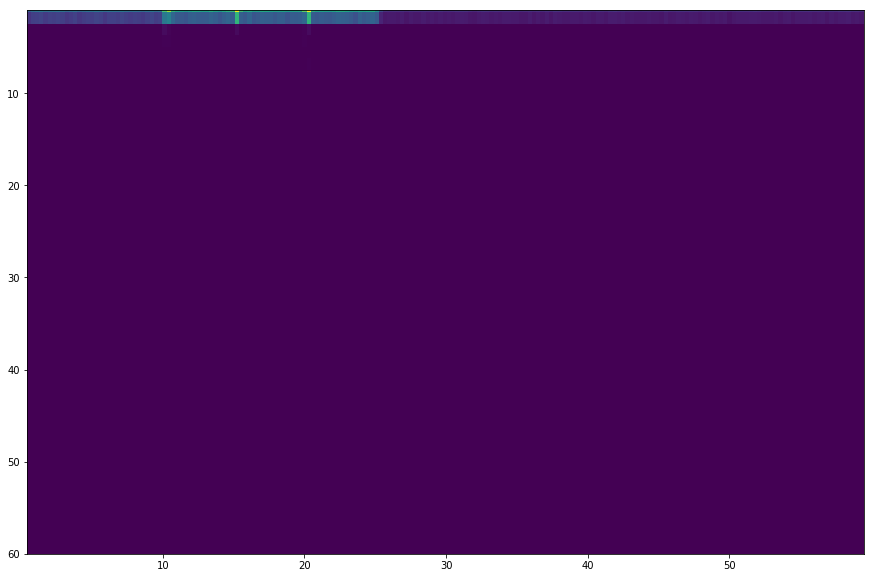

In [203]:
freqs_v, times_v, Sx_v = signal.spectrogram(Mv_mild_s095_2_02fs_mean_rate_total_per_time_point, fs=5000, window='hanning',
                                          nperseg=4000, noverlap=2500,
                                          detrend=False, scaling='spectrum')
freqs_d, times_d, Sx_d = signal.spectrogram(Md_mild_s095_2_02fs_mean_rate_total_per_time_point, fs=5000, window='hanning',
                                          nperseg=4000, noverlap=2500,
                                          detrend=False, scaling='spectrum')
Sx_dif = Sx_v - Sx_d
plt.figure(figsize=(15, 10))
plt.ylim(60)
plt.pcolormesh(times_s, freqs_s, Sx_v, cmap='viridis')

In [204]:
power, freq = extract_frequencies(Mv_8pA_baseline_mean,True, frequency)

In [9]:
Md_8pA_baseline_mean,Mv_8pA_baseline_mean,Md_8pA_to_cognitive_mean,Mv_8pA_to_cognitive_mean,Md_8pA_to_emotional_mean,Mv_8pA_to_emotional_mean,Md_8pA_rest_mean,Mv_8pA_rest_mean = divide_epochs(Md_total_rate_mild_8pA_02ms_fs,Mv_total_rate_mild_8pA_02ms_fs)

Md_prior_baseline_mean,Mv_prior_baseline_mean,Md_prior_to_cognitive_mean,Mv_prior_to_cognitive_mean,Md_prior_to_emotional_mean,Mv_prior_to_emotional_mean,Md_prior_rest_mean,Mv_prior_rest_mean = divide_epochs( Md_total_rate_mild_prior_02fs,Mv_total_rate_mild_prior_02fs)

Md_s095_baseline_mean,Mv_s095_baseline_mean,Md_s095_to_cognitive_mean,Mv_s095_to_cognitive_mean,Md_s095_to_emotional_mean,Mv_s095_to_emotional_mean,Md_s095_rest_mean,Mv_s095_rest_mean = divide_epochs(Md_total_rate_mild_s095_02ms_fs,Mv_total_rate_mild_s095_02ms_fs)

Md_healthy_baseline_mean,Mv_healthy_baseline_mean,Md_healthy_to_cognitive_mean,Mv_healthy_to_cognitive_mean,Md_healthy_to_emotional_mean,Mv_healthy_to_emotional_mean,Md_healthy_rest_mean,Mv_healthy_rest_mean = divide_epochs( Md_total_rate_healthy_prior_02ms_fs,Mv_total_rate_healthy_prior_02ms_fs)



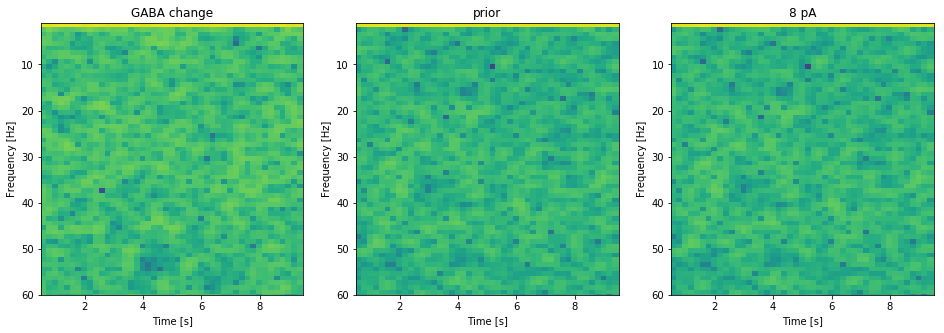

In [167]:
plot_time_frequency (Md_s095_baseline_mean, Md_8pA_baseline_mean, Md_prior_baseline_mean, 'dlPFC baseline three conditions')

In [8]:



def divide_epochs(Md_total_rate, Mv_total_rate):
    
    Md_to_cognitive_mean = np.mean(extract_response_to_cognitive(Md_total_rate),axis = 0)
    Mv_to_emotional_mean  = np.mean(extract_response_to_emotional(Mv_total_rate),axis = 0)

    Md_to_emotional_mean= np.mean(extract_response_to_emotional(Md_total_rate),axis = 0)
    Mv_to_cognitive_mean  = np.mean(extract_response_to_cognitive(Mv_total_rate),axis = 0)

    Md_baseline_mean = np.mean(extract_baseline_firing(Md_total_rate),axis = 0)
    Mv_baseline_mean = np.mean(extract_baseline_firing(Mv_total_rate),axis = 0)

    Md_rest_mean = np.mean(extract_rest_firing(Md_total_rate),axis = 0)
    Mv_rest_mean = np.mean(extract_rest_firing(Mv_total_rate),axis = 0)
    
    return(Md_baseline_mean,Mv_baseline_mean,Md_to_cognitive_mean,Mv_to_cognitive_mean,Md_to_emotional_mean,Mv_to_emotional_mean,Md_rest_mean,Mv_rest_mean)


    

def plot_time_frequency (condition_s, condition_t, condition_p, name):

    freqs_s, times_s, Sx_s = signal.spectrogram(condition_s, fs=5000, window='hanning',
                                          nperseg=5000, noverlap=4000,
                                          detrend=False, scaling='spectrum')
    freqs_8pA, times_8pA, Sx_8pA = signal.spectrogram(condition_t, fs=5000, window='hanning',
                                          nperseg=5000, noverlap=4000,
                                          detrend=False, scaling='spectrum')
    freqs_p, times_p, Sx_p = signal.spectrogram(condition_p, fs=5000, window='hanning',
                                          nperseg=5000, noverlap=4000,
                                          detrend=False, scaling='spectrum')

    plt.figure(figsize=(16, 5))

    plt.subplot(131)
    plt.ylim(60)
    plt.pcolormesh(times_s, freqs_s, 10 * np.log10(Sx_s), cmap='viridis')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]');
    plt.title('GABA change')

    plt.subplot(132)
    plt.ylim(60)
    plt.pcolormesh(times_p, freqs_p, 10 * np.log10(Sx_p), cmap='viridis')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]');
    plt.title('prior')

    plt.subplot(133)
    plt.ylim(60)

    plt.pcolormesh(times_8pA, freqs_8pA, 10 * np.log10(Sx_8pA), cmap='viridis')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]');
    plt.title('8 pA')


    # plt.show()
    plt.savefig(name)
    
def plot_mean_power(Md_total_rate1, Mv_total_rate1, Md_total_rate2,Mv_total_rate2,Md_total_rate3,Mv_total_rate3,mean,name1,name2,name3, name4):
    
    
    Md1_baseline_mean,Mv1_baseline_mean,Md1_to_cognitive_mean,Mv1_to_cognitive_mean,Md1_to_emotional_mean,Mv1_to_emotional_mean,Md1_rest_mean,Mv1_rest_mean = divide_epochs(Md_total_rate1,Mv_total_rate1)

    Md2_baseline_mean,Mv2_baseline_mean,Md2_to_cognitive_mean,Mv2_to_cognitive_mean,Md2_to_emotional_mean,Mv2_to_emotional_mean,Md2_rest_mean,Mv2_rest_mean = divide_epochs(Md_total_rate2,Mv_total_rate2)
    Md3_baseline_mean,Mv3_baseline_mean,Md3_to_cognitive_mean,Mv3_to_cognitive_mean,Md3_to_emotional_mean,Mv3_to_emotional_mean,Md3_rest_mean,Mv3_rest_mean = divide_epochs(Md_total_rate3,Mv_total_rate3)

    
    total_alpha_power1 = []
    total_alpha_power2 = []
    total_alpha_power3 = []
    
    total_beta_power1 = []
    total_beta_power2 = []
    total_beta_power3 = []

    total_theta_power1 = []
    total_theta_power2 = []
    total_theta_power3 = []
    
 
    alpha_power1_std=[]
    alpha_power2_std = []
    alpha_power3_std = []
    
    
    beta_power1_std=[]
    beta_power2_std = []
    beta_power3_std = []
    
    
    theta_power1_std=[]
    theta_power2_std = []
    theta_power3_std = []
    
  
    alpha_power1_b, frequency1_b = extract_frequencies(Md1_baseline_mean,mean, 'alpha')
    alpha_power1_e, frequency1_e = extract_frequencies(Md1_to_emotional_mean,mean, 'alpha')
    alpha_power1_c, frequency1_c = extract_frequencies(Md1_to_cognitive_mean,mean, 'alpha')
    alpha_power1_r, frequency1_r = extract_frequencies(Md1_rest_mean,mean, 'alpha')
    
    beta_power1_b, frequency1_b = extract_frequencies(Md1_baseline_mean,mean, 'beta')
    beta_power1_e, frequency1_e = extract_frequencies(Md1_to_emotional_mean,mean, 'beta')
    beta_power1_c, frequency1_c = extract_frequencies(Md1_to_cognitive_mean,mean, 'beta')
    beta_power1_r, frequency1_r = extract_frequencies(Md1_rest_mean,mean, 'beta')
    
    theta_power1_b, frequency1_b = extract_frequencies(Md1_baseline_mean,mean, 'theta')
    theta_power1_e, frequency1_e = extract_frequencies(Md1_to_emotional_mean,mean, 'theta')
    theta_power1_c, frequency1_c = extract_frequencies(Md1_to_cognitive_mean,mean, 'theta')
    theta_power1_r, frequency1_r = extract_frequencies(Md1_rest_mean,mean, 'theta')
    
    
    alpha_power1_std.append(np.std(np.asarray(alpha_power1_b)))
    alpha_power1_std.append(np.std(np.asarray(alpha_power1_e)))
    alpha_power1_std.append(np.std(np.asarray(alpha_power1_c)))
    alpha_power1_std.append(np.std(np.asarray(alpha_power1_r)))
    
    beta_power1_std.append(np.std(np.asarray(beta_power1_b)))
    beta_power1_std.append(np.std(np.asarray(beta_power1_e)))
    beta_power1_std.append(np.std(np.asarray(beta_power1_c)))
    beta_power1_std.append(np.std(np.asarray(beta_power1_r)))
    
    theta_power1_std.append(np.std(np.asarray(theta_power1_b)))
    theta_power1_std.append(np.std(np.asarray(theta_power1_e)))
    theta_power1_std.append(np.std(np.asarray(theta_power1_c)))
    theta_power1_std.append(np.std(np.asarray(theta_power1_r)))
    
    
    total_alpha_power1.append(np.mean(np.asarray(alpha_power1_b)))
    total_alpha_power1.append(np.mean(np.asarray(alpha_power1_e)))
    total_alpha_power1.append(np.mean(np.asarray(alpha_power1_c)))
    total_alpha_power1.append(np.mean(np.asarray(alpha_power1_r)))
    
    total_beta_power1.append(np.mean(np.asarray(beta_power1_b)))
    total_beta_power1.append(np.mean(np.asarray(beta_power1_e)))
    total_beta_power1.append(np.mean(np.asarray(beta_power1_c)))
    total_beta_power1.append(np.mean(np.asarray(beta_power1_r)))
    
    
    total_theta_power1.append(np.mean(np.asarray(theta_power1_b)))
    total_theta_power1.append(np.mean(np.asarray(theta_power1_e)))
    total_theta_power1.append(np.mean(np.asarray(theta_power1_c)))
    total_theta_power1.append(np.mean(np.asarray(theta_power1_r)))
    
    
    
    alpha_power2_b, frequency2_b = extract_frequencies(Md2_baseline_mean,mean, 'alpha')
    alpha_power2_e, frequency2_e = extract_frequencies(Md2_to_emotional_mean,mean, 'alpha')
    alpha_power2_c, frequency2_c = extract_frequencies(Md2_to_cognitive_mean,mean,'alpha')
    alpha_power2_r, frequency2_r = extract_frequencies(Md2_rest_mean,mean, 'alpha')
    
    beta_power2_b, frequency2_b = extract_frequencies(Md2_baseline_mean,mean, 'beta')
    beta_power2_e, frequency2_e = extract_frequencies(Md2_to_emotional_mean,mean, 'beta')
    beta_power2_c, frequency2_c = extract_frequencies(Md2_to_cognitive_mean,mean, 'beta')
    beta_power2_r, frequency2_r = extract_frequencies(Md2_rest_mean,mean, 'beta')
    
    theta_power2_b, frequency2_b = extract_frequencies(Md2_baseline_mean,mean, 'theta')
    theta_power2_e, frequency2_e = extract_frequencies(Md2_to_emotional_mean,mean, 'theta')
    theta_power2_c, frequency2_c = extract_frequencies(Md2_to_cognitive_mean,mean, 'theta')
    theta_power2_r, frequency2_r = extract_frequencies(Md2_rest_mean,mean, 'theta')
    
    alpha_power2_std.append(np.std(np.asarray(alpha_power2_b)))
    alpha_power2_std.append(np.std(np.asarray(alpha_power2_e)))
    alpha_power2_std.append(np.std(np.asarray(alpha_power2_c)))
    alpha_power2_std.append(np.std(np.asarray(alpha_power2_r)))
    
    beta_power2_std.append(np.std(np.asarray(beta_power2_b)))
    beta_power2_std.append(np.std(np.asarray(beta_power2_e)))
    beta_power2_std.append(np.std(np.asarray(beta_power2_c)))
    beta_power2_std.append(np.std(np.asarray(beta_power2_r)))
    
    theta_power2_std.append(np.std(np.asarray(theta_power2_b)))
    theta_power2_std.append(np.std(np.asarray(theta_power2_e)))
    theta_power2_std.append(np.std(np.asarray(theta_power2_c)))
    theta_power2_std.append(np.std(np.asarray(theta_power2_r)))
   
    
    total_alpha_power2.append(np.mean(np.asarray(alpha_power2_b)))
    total_alpha_power2.append(np.mean(np.asarray(alpha_power2_e)))
    total_alpha_power2.append(np.mean(np.asarray(alpha_power2_c)))
    total_alpha_power2.append(np.mean(np.asarray(alpha_power2_r)))
    
    total_beta_power2.append(np.mean(np.asarray(beta_power2_b)))
    total_beta_power2.append(np.mean(np.asarray(beta_power2_e)))
    total_beta_power2.append(np.mean(np.asarray(beta_power2_c)))
    total_beta_power2.append(np.mean(np.asarray(beta_power2_r)))
    
    
    total_theta_power2.append(np.mean(np.asarray(theta_power2_b)))
    total_theta_power2.append(np.mean(np.asarray(theta_power2_e)))
    total_theta_power2.append(np.mean(np.asarray(theta_power2_c)))
    total_theta_power2.append(np.mean(np.asarray(theta_power2_r)))
    
    
    alpha_power3_b, frequency3_b = extract_frequencies(Md3_baseline_mean,mean, 'alpha')
    alpha_power3_e, frequency3_e = extract_frequencies(Md3_to_emotional_mean,mean, 'alpha')
    alpha_power3_c, frequency3_c = extract_frequencies(Md3_to_cognitive_mean,mean, 'alpha')
    alpha_power3_r, frequency3_r = extract_frequencies(Md3_rest_mean,mean, 'alpha')

    beta_power3_b, frequency3_b = extract_frequencies(Md3_baseline_mean,mean, 'beta')
    beta_power3_e, frequency3_e = extract_frequencies(Md3_to_emotional_mean,mean, 'beta')
    beta_power3_c, frequency3_c = extract_frequencies(Md3_to_cognitive_mean,mean, 'beta')
    beta_power3_r, frequency3_r = extract_frequencies(Md3_rest_mean,mean, 'beta')
    
    theta_power3_b, frequency3_b = extract_frequencies(Md3_baseline_mean,mean, 'theta')
    theta_power3_e, frequency3_e = extract_frequencies(Md3_to_emotional_mean,mean, 'theta')
    theta_power3_c, frequency3_c = extract_frequencies(Md3_to_cognitive_mean,mean, 'theta')
    theta_power3_r, frequency3_r = extract_frequencies(Md3_rest_mean,mean, 'theta')
    
    
    alpha_power3_std.append(np.std(np.asarray(alpha_power3_b)))
    alpha_power3_std.append(np.std(np.asarray(alpha_power3_e)))
    alpha_power3_std.append(np.std(np.asarray(alpha_power3_c)))
    alpha_power3_std.append(np.std(np.asarray(alpha_power3_r)))
    
    beta_power3_std.append(np.std(np.asarray(beta_power3_b)))
    beta_power3_std.append(np.std(np.asarray(beta_power3_e)))
    beta_power3_std.append(np.std(np.asarray(beta_power3_c)))
    beta_power3_std.append(np.std(np.asarray(beta_power3_r)))
    
    theta_power3_std.append(np.std(np.asarray(theta_power3_b)))
    theta_power3_std.append(np.std(np.asarray(theta_power3_e)))
    theta_power3_std.append(np.std(np.asarray(theta_power3_c)))
    theta_power3_std.append(np.std(np.asarray(theta_power3_r)))
    
    total_alpha_power3.append(np.mean(np.asarray(alpha_power3_b)))
    total_alpha_power3.append(np.mean(np.asarray(alpha_power3_e)))
    total_alpha_power3.append(np.mean(np.asarray(alpha_power3_c)))
    total_alpha_power3.append(np.mean(np.asarray(alpha_power3_r)))
    
    total_beta_power3.append(np.mean(np.asarray(beta_power3_b)))
    total_beta_power3.append(np.mean(np.asarray(beta_power3_e)))
    total_beta_power3.append(np.mean(np.asarray(beta_power3_c)))
    total_beta_power3.append(np.mean(np.asarray(beta_power3_r)))
    
    
    total_theta_power3.append(np.mean(np.asarray(theta_power3_b)))
    total_theta_power3.append(np.mean(np.asarray(theta_power3_e)))
    total_theta_power3.append(np.mean(np.asarray(theta_power3_c)))
    total_theta_power3.append(np.mean(np.asarray(theta_power3_r)))
    
    
    epochs = [1,2,3,4]
    plt.figure(figsize=(18, 5))
    plt.subplot(131)
    

    plt.errorbar(epochs,total_alpha_power1,yerr=np.asarray(alpha_power1_std)/2, marker='s',label = name1)
    plt.errorbar(epochs,total_alpha_power2,yerr=np.asarray(alpha_power2_std)/2, marker='s',label = name2)
    plt.errorbar(epochs,total_alpha_power3,yerr=np.asarray(alpha_power3_std)/2, marker='s',label = name3)

    
    plt.ylabel('Power')
    plt.xlabel('Epoch')
    plt.legend()
    plt.title('Alpha frequency')
    
    
    plt.subplot(132)
    
    plt.errorbar(epochs,total_beta_power1,yerr=np.asarray(beta_power1_std)/2, marker='s',label = name1)
    plt.errorbar(epochs,total_beta_power2,yerr=np.asarray(beta_power2_std)/2, marker='s',label = name2)
    plt.errorbar(epochs,total_beta_power3,yerr=np.asarray(beta_power3_std)/2, marker='s',label = name3)
    
    plt.ylabel('Power')
    plt.xlabel('Epoch')
    plt.legend()
    plt.title('Beta frequency')
    
    plt.subplot(133)
    
    plt.errorbar(epochs,total_theta_power1,yerr=np.asarray(theta_power1_std)/2, marker='s',label = name1)
    plt.errorbar(epochs,total_theta_power2,yerr=np.asarray(theta_power2_std)/2, marker='s',label = name2)
    plt.errorbar(epochs,total_theta_power3,yerr=np.asarray(theta_power2_std)/2, marker='s',label = name3)
    
    plt.ylabel('Power')
    plt.xlabel('Epoch')
    plt.legend()
    plt.title('Theta frequency')
    
    plt.savefig(name4)

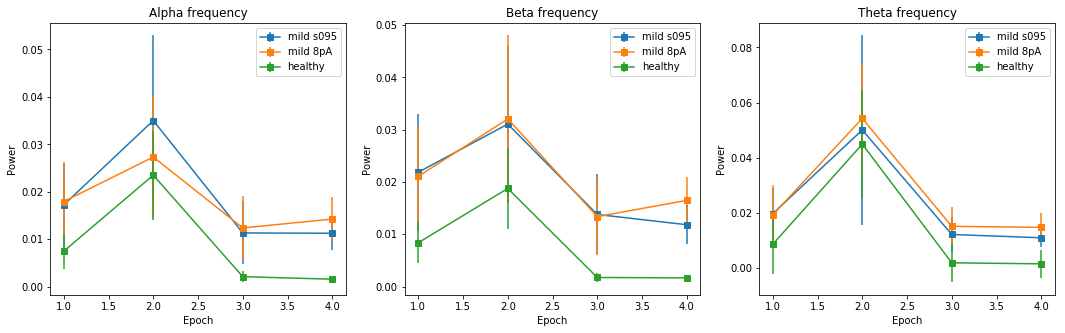

In [16]:
plot_mean_power(Mv_total_rate_mild_s095_02ms_fs, Mv_total_rate_mild_s095_02ms_fs, Mv_total_rate_mild_8pA_02ms_fs,Mv_total_rate_mild_8pA_02ms_fs,Mv_total_rate_healthy_prior_02ms_fs,Mv_total_rate_healthy_prior_02ms_fs,True, 'mild s095','mild 8pA','healthy','vACC absolute power comparison two conditions')

In [12]:
dataman = DataManager('Mild_prior_part2')
tdcs_current, Md_rate_mild_prior_2,Mv_rate_mild_prior_2 = zip(*dataman.values())
dataman = DataManager('Mild_prior_part1')
dcs_current, Md_rate_mild_prior_1,Mv_rate_mild_prior_ = zip(*dataman.values())

Md_total_rate_mild_prior = np.vstack((Md_rate_mild_prior_2,Md_rate_mild_prior_1))
Mv_total_rate_mild_prior = np.vstack((Mv_rate_mild_prior_2,Md_rate_mild_prior_1))


In [7]:
dataman = DataManager('Healthy_membrane_1to10')
tdcs_current, Md_rate_membrane,Md_potential= zip(*dataman.values())

In [5]:
dataman = DataManager('Mild_8pA_part2')
tdcs_current, Md_rate_mild_8pA,Mv_rate_mild_8pA= zip(*dataman.values())
dataman2 = DataManager('Mild_8pA')
tdcs_current, Md_rate_mild_8pA_2,Mv_rate_mild_8pA_2= zip(*dataman2.values())

Md_total_rate_mild_8pA = np.vstack((Md_rate_mild_8pA,Md_rate_mild_8pA_2))
Mv_total_rate_mild_8pA = np.vstack((Mv_rate_mild_8pA,Mv_rate_mild_8pA_2))

In [ ]:

    
dataman = DataManager('Moderate_synaptic_gating095')    
tdcs_current, moderate_Md_rate_s095,moderate_Mv_rate_s095= zip(*dataman.values())

# Md_total_rate_mild_8pA = np.vstack((Md_rate_mild_8pA,Md_rate_mild_8pA_2))
# Mv_total_rate_mild_8pA = np.vstack((Mv_rate_mild_8pA,Mv_rate_mild_8pA_2))

In [6]:
# dataman2 = DataManager('Healthy_prior')
# tdcs_current= []
# Mv = []
# Md =[]
# Mvi = []
# Mdi = []
# tdcs_current, healthy_Md_rate,healthy_Mv_rate = zip(*dataman2.values())
Md_rate_healthy_1 = np.asarray(healthy_Md_rate)
Mv_rate_healthy_1 = np.asarray(healthy_Mv_rate)
Md_total_rate_healthy = np.vstack((Md_rate_healthy_1, Md_rate_healthy_2))
Mv_total_rate_healthy = np.vstack((Mv_rate_healthy_1, Mv_rate_healthy_2))

# tdcs_current, Md_rate_healthy_2,Mv_rate_healthy_2= zip(*dataman.values())

In [5]:
dataman = DataManager('Healthy_multiple_gating095')
tdcs_current= []
Mv = []
Md =[]
Mvi = []
Mdi = []
tdcs_current, Md_healthy_gating095, Mv_healthy_gating095= zip(*dataman.values())



In [79]:
Md_mild_8pA_cognitive = extract_response_to_cognitive (Md_total_rate_mild_8pA_02ms_fs)
Md_mild_prior_cognitive = extract_response_to_cognitive (Md_total_rate_mild_prior_02fs)
# sp = np.fft.fft(Md_prior_cognitive[0], norm="ortho")
# t = np.linspace(10,25,num = 74999)
# freq = np.fft.fftfreq(t.shape[-1])
# plt.plot(freq, sp.real, freq, sp.imag)

In [9]:
def extract_response_to_cognitive(firing_rate):
    t1 = 125001
    t2 = 200000
    response = firing_rate[0:,t1:t2]
    return response

def extract_response_to_emotional(firing_rate):
    t1 = 50001
    t2 = 125000
    response = firing_rate[:,t1:t2]
    return response
def extract_baseline_firing(firing_rate):
    t1 = 0
    t2 = 50000
    response = firing_rate[:,t1:t2]
    return response

def extract_rest_firing(firing_rate):
    t1 = 200001
    t2 = 300000
    response = firing_rate[0:,t1:t2]
    return response


In [191]:
Md_mild_s095_2_02fs_mean_rate_total_per_time_point = np.mean(Md_total_rate_mild_s095_1_02ms_fs, axis = 0)
Mv_mild_s095_2_02fs_mean_rate_total_per_time_point = np.mean(Mv_total_rate_mild_s095_1_02ms_fs, axis = 0)


In [8]:
Md_mild_mean_rate_total_per_time_point = np.mean(Md_total_rate_mild_prior, axis = 0)
Mv_mild_mean_rate_total_per_time_point = np.mean(Mv_total_rate_mild_prior, axis = 0)
Md_mild_mean_rate_total_per_trial = np.mean(Md_total_rate_mild_prior, axis = 1)
Mv_mild_mean_rate_total_per_trial = np.mean(Mv_total_rate_mild_prior, axis = 1)

In [10]:
Md_mild_8pA_mean_rate_total_per_time_point = np.mean(Md_total_rate_mild_8pA, axis = 0)
Mv_mild_8pA_mean_rate_total_per_time_point = np.mean(Mv_total_rate_mild_8pA, axis = 0)
Md_mild_8pA_mean_rate_total_per_trial = np.mean(Md_total_rate_mild_8pA, axis = 1)
Mv_mild_8pA_mean_rate_total_per_trial = np.mean(Mv_total_rate_mild_8pA, axis = 1)

In [26]:
    freqs_s, times_s, Sx_s = signal.spectrogram(response_Md_s095, fs=200, window='hanning',
                                          nperseg=25, noverlap=24,
                                          detrend=False, scaling='spectrum')
    freqs_8pA, times_8pA, Sx_8pA = signal.spectrogram(response_Md_8pA, fs=200, window='hanning',
                                          nperseg=35, noverlap=30,
                                          detrend=False, scaling='spectrum')
    freqs_p, times_p, Sx_p = signal.spectrogram(response_Md_prior, fs=200, window='hanning',
                                          nperseg=35, noverlap=30,
                                          detrend=False, scaling='spectrum')

    plt.figure(figsize=(16, 5))

    plt.subplot(131)
    # plt.ylim(20)
    plt.pcolormesh(times_s, freqs_s, 10 * np.log10(Sx_s), cmap='viridis')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]');
    plt.title('GABA change')

    plt.subplot(132)
    # plt.ylim(20)
    plt.pcolormesh(times_p, freqs_p, 10 * np.log10(Sx_p), cmap='viridis')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]');
    plt.title('prior')

    plt.subplot(133)
    # plt.ylim(20)

    plt.pcolormesh(times_8pA, freqs_8pA, 10 * np.log10(Sx_8pA), cmap='viridis')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]');
    plt.title('8 pA')


    # plt.show()
    plt.savefig('time all frequencies over three conditions')healthy_Md_mean_rate= np.mean(healthy_Md_rate, axis = 0)
healthy_Mv_mean_rate = np.mean(healthy_Mv_rate, axis = 0)
healthy_Md_std= np.std(healthy_Md_rate, axis = 0)epoch
healthy_Mv_std = np.std(healthy_Mv_rate, axis = 0)

In [3]:




moderate_Md_mean_rate_s095 = np.mean(moderate_Md_rate_s095, axis = 0)
moderate_Mv_mean_rate_s095 = np.mean(moderate_Mv_rate_s095, axis = 0)
# Mvi_mean_healthy_synaptic_gating_095 = np.mean(Mvi_rates_moderate_clean, axis = 0)
# Mdi_mean_healthy_synaptic_gating_095 = np.mean(Mdi_rates_moderate_clean, axis = 0)



moderate_Md_std_rate_s095 = np.std(moderate_Md_rate_s095, axis = 0)
moderate_Mv_std_rate_s095 = np.std(moderate_Mv_rate_s095, axis = 0)

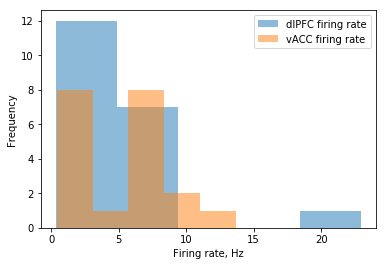

In [10]:
n, bins, patches = plt.hist(Md_total_mean_rate_healthy_per_trial,bins = 5, alpha = 0.5, label = 'dlPFC firing rate' )
n1, bins1, patches1 = plt.hist(Mv_total_mean_rate_healthy_per_trial,bins = 5, alpha = 0.5, label = 'vACC firing rate')
plt.ylabel('Frequency')
plt.xlabel('Firing rate, Hz')
plt.legend()
# plt.savefig('Distribution of mean firing rates per 20 trials')

In [25]:
significance_test(Md_total_rate_mild_8pA_02ms_fs, Mv_total_rate_mild_8pA_02ms_fs,Md_total_rate_mild_s095_02ms_fs, Mv_total_rate_mild_s095_02ms_fs,4)

Statistics=1117460498460.500, p=0.000
Different distribution for dlPFC response to cognitive (reject H0)
Statistics=1081594630392.000, p=0.000
Different distribution for vACC response to cognitive (reject H0)


In [22]:
# Mann-Whitney U Test
def significance_test(Md_1,Mv_1, Md_2, Mv_2, epoch):
    
    Md_1_to_cognitive = extract_response_to_cognitive(Md_1)
    Mv_1_to_emotional  = extract_response_to_emotional(Mv_1)
    
    Md_1_to_emotional = extract_response_to_emotional(Md_1)
    Mv_1_to_cognitive  = extract_response_to_cognitive(Mv_1)
    
    Md_1_baseline = extract_baseline_firing(Md_1)
    Mv_1_baseline = extract_baseline_firing(Mv_1)
    
    Md_1_rest = extract_rest_firing(Md_1)
    Mv_1_rest = extract_rest_firing(Mv_1)
    
    Md_2_to_cognitive = extract_response_to_cognitive(Md_2)
    Mv_2_to_emotional  = extract_response_to_emotional(Mv_2)
    
    Md_2_to_emotional = extract_response_to_emotional(Md_2)
    Mv_2_to_cognitive  = extract_response_to_cognitive(Mv_2)
    
    
    Md_2_baseline = extract_baseline_firing(Md_2)
    Mv_2_baseline = extract_baseline_firing(Mv_2)
    
    Md_2_rest = extract_rest_firing(Md_2)
    Mv_2_rest = extract_rest_firing(Mv_2)
    
    if epoch == 1:
        
        stat, p = mannwhitneyu(Md_2_baseline.flatten(), Md_1_baseline.flatten())
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution for dlPFC baseline(fail to reject H0)')
        else:
            print('Different distribution for dlPFC baseline(reject H0)')
        stat, p = mannwhitneyu(Mv_2_baseline.flatten(), Mv_1_baseline.flatten())
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution for vACC baseline (fail to reject H0)')
        else:
            print('Different distribution for vACC baseline (reject H0)')
            
    if epoch ==2:
        
        stat, p = mannwhitneyu(Md_2_to_emotional.flatten(), Md_1_to_emotional.flatten())
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution for dlPFC response to emotional(fail to reject H0)')
        else:
            print('Different distribution for dlPFC response to emotional (reject H0)')
        stat, p = mannwhitneyu(Mv_2_to_emotional.flatten(), Mv_1_to_emotional.flatten())
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution for vACC responsece to emotional (fail to reject H0)')
        else:
            print('Different distribution for vACC response to emotional (reject H0)')
            
    if epoch ==3:
        
        stat, p = mannwhitneyu(Md_2_to_cognitive.flatten(), Md_1_to_cognitive.flatten())
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution for dlPFC response to cognitive(fail to reject H0)')
        else:
            print('Different distribution for dlPFC response to cognitive (reject H0)')
        stat, p = mannwhitneyu(Mv_2_to_cognitive.flatten(), Mv_1_to_cognitive.flatten())
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution for vACC responsece to cognitive (fail to reject H0)')
        else:
            print('Different distribution for vACC response to cognitive (reject H0)')
            
    if epoch ==4:
        
        stat, p = mannwhitneyu(Md_2_rest.flatten(), Md_1_rest.flatten())
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution for dlPFC rest(fail to reject H0)')
        else:
            print('Different distribution for dlPFC rest (reject H0)')
        stat, p = mannwhitneyu(Mv_2_rest.flatten(), Mv_1_rest.flatten())
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution for vACC rest(fail to reject H0)')
        else:
            print('Different distribution for vACC rest(reject H0)')

Text(0,0.5,'Frequency')

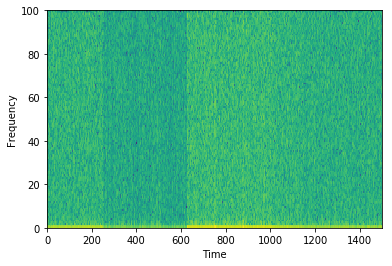

In [31]:
# plt.specgram(Mv_mild_s095_2_02fs_mean_rate_total_per_time_point,Fs=200)
plt.specgram(Md_mild_s095_2_02fs_mean_rate_total_per_time_point,Fs=200)

plt.xlabel('Time')

plt.ylabel('Frequency')

In [15]:


Md_mean_rate_mild_prior = np.mean(Md_total_rate_mild_prior, axis = 0) 
Mv_mean_rate_mild_prior = np.mean(Mv_total_rate_mild_prior, axis = 0)

Md_std_rate_mild_prior = np.std(Md_total_rate_mild_prior, axis = 0)
Mv_std_rate_mild_prior  = np.std(Mv_total_rate_mild_prior, axis = 0)

y_upper_Md = Md_mean_rate_mild_prior +Md_std_rate_mild_prior/2
y_lower_Md = Md_mean_rate_mild_prior - Md_mean_rate_mild_prior/2

y_upper_Mv = Mv_mean_rate_mild_prior +Mv_std_rate_mild_prior/2
y_lower_Mv = Mv_mean_rate_mild_prior - Mv_std_rate_mild_prior/2

In [23]:
# This is for 20 trials


Md_total_mean_rate_mild_8pA = np.mean(Md_total_rate_mild_8pA, axis = 0) 
Mv_total_mean_rate_mild_8pA = np.mean(Mv_total_rate_mild_8pA, axis = 0)

Md_total_std_rate_mild_8pA = np.std(Md_total_rate_mild_8pA, axis = 0)
Mv_total_std_rate_mild_8pA  = np.std(Mv_total_rate_mild_8pA, axis = 0)

y_upper_Md = Md_total_mean_rate_mild_8pA +Md_total_std_rate_mild_8pA/2
y_lower_Md = Md_total_mean_rate_mild_8pA - Md_total_mean_rate_mild_8pA/2

y_upper_Mv = Mv_total_mean_rate_mild_8pA +Mv_total_std_rate_mild_8pA/2
y_lower_Mv = Mv_total_mean_rate_mild_8pA - Mv_total_std_rate_mild_8pA/2

In [9]:


Md_total_std_mild_prior_02fs_red = np.std(Md_total_rate_mild_prior_02fs_red, axis = 0)
Mv_total_std_mild_prior_02fs_red  = np.std(Mv_total_rate_mild_prior_02fs_red, axis = 0)

y_upper_Md = Md_mean_rate_mild_prior_02fs_red +Md_total_std_mild_prior_02fs_red/2
y_lower_Md = Md_mean_rate_mild_prior_02fs_red - Md_total_std_mild_prior_02fs_red/2

y_upper_Mv = Mv_mean_rate_mild_prior_02fs_red +Mv_total_std_mild_prior_02fs_red/2
y_lower_Mv = Mv_mean_rate_mild_prior_02fs_red - Mv_total_std_mild_prior_02fs_red/2

In [52]:

healthy_gating095_Md_mean_rate = np.mean(Md_healthy_gating095, axis = 0)
healthy_gating095_Mv_mean_rate = np.mean(Mv_healthy_gating095, axis = 0)
# Mvi_mean_healthy_synaptic_gating_095 = np.mean(Mvi_rates_moderate_clean, axis = 0)
# Mdi_mean_healthy_synaptic_gating_095 = np.mean(Mdi_rates_moderate_clean, axis = 0)



healthy_gating095_Md_std_rate = np.std(Md_healthy_gating095, axis = 0)
healthy_gating095_Mv_std_rate = np.std(Mv_healthy_gating095, axis = 0)

In [4]:

Mv_mean_healthy_synaptic_gating_095 = np.mean(Mv_healthy_gating095, axis = 0)
Md_mean_healthy_synaptic_gating_095 = np.mean(Md_healthy_gating095, axis = 0)
# Mvi_mean_healthy_synaptic_gating_095 = np.mean(Mvi_rates_moderate_clean, axis = 0)
# Mdi_mean_healthy_synaptic_gating_095 = np.mean(Mdi_rates_moderate_clean, axis = 0)



Mv_std_healthy_synaptic_gating_095 = np.std(Mv_healthy_gating095, axis = 0)
Md_std_healthy_synaptic_gating_095 = np.std(Md_healthy_gating095, axis = 0)
# Mvi_std_moderate_clean = np.std(Mvi_rates_moderate_clean, axis = 0)
# Mdi_std_moderate_clean = np.std(Mdi_rates_moderate_clean, axis = 0)

In [51]:
y_upper_Mv = healthy_Mv_mean_rate +healthy_Mv_std_rate/2
y_lower_Mv = healthy_Mv_mean_rate - healthy_Mv_std_rate/2

y_upper_Md = healthy_Md_mean_rate +healthy_Md_std_rate/2
y_lower_Md = healthy_Md_mean_rate - healthy_Md_std_rate/2

In [5]:
y_upper_Mv = Mv_mean_healthy_synaptic_gating_095 + Mv_std_healthy_synaptic_gating_095/2
y_lower_Mv = Mv_mean_healthy_synaptic_gating_095 - Mv_std_healthy_synaptic_gating_095/2

y_upper_Md = Md_mean_healthy_synaptic_gating_095 + Md_std_healthy_synaptic_gating_095/2
y_lower_Md = Md_mean_healthy_synaptic_gating_095 - Md_std_healthy_synaptic_gating_095/2

# y_upper_Mdi = Mdi_mean_moderate_clean + Mdi_std_moderate_clean/2
# y_lower_Mdi = Md_mean_moderate_clean - Mdi_std_moderate_clean/2

# y_upper_Mvi = Mvi_mean_moderate_clean + Mvi_std_moderate_clean/2
# y_lower_Mvi = Mvi_mean_moderate_clean - Mvi_std_moderate_clean/2

In [11]:
# from scipy import stats
time = np.arange(0, 60,0.2)

Md_healthy_gating095_mean_per_subject = []
Md_healthy_mean_per_subject = []
Md_mild_8pA_mean_per_subject = []

for i in range(20):
    Md_mild_8pA_mean_per_subject.append(np.mean(Md_rate_mild_8pA[i] ))
#     Md_healthy_gating095_mean_per_subject.append(np.mean(Md_rate_mild_8pA[i] ))

#     Md_healthy_mean_per_subject.append(np.mean(healthy_Md_rate[i]))
#     Md_healthy_mean_per_subject.append(np.mean(healthy_Mv_rate[i]))

plt.hist(Md_mild_8pA_mean_per_subject)
# plt.hist(Md_healthy_mean_per_subject)
# plt.savefig('Healthy synaptic gating 095 Mean per subject')

IndexError: tuple index out of range

In [69]:
def plot_trace(Md_total_rate_1, Mv_total_rate_1, Md_total_rate_2, Mv_total_rate_2, subtract, name1, name2,figure_name):

    time = np.arange(0, 60,0.2)
    
    if subtract:
        
        Md_total_rate_1, Mv_total_rate_1 = reduce_sampling(Md_total_rate_1, Mv_total_rate_1)
        Md_mean_rate_1 = np.mean(Md_total_rate_1, axis = 0)
        Mv_mean_rate_1 = np.mean(Mv_total_rate_1, axis = 0) 
        
        Md_total_rate_2, Mv_total_rate_2 = reduce_sampling(Md_total_rate_2, Mv_total_rate_2)
        Md_mean_rate_2 = np.mean(Md_total_rate_2, axis = 0)
        Mv_mean_rate_2 = np.mean(Mv_total_rate_2, axis = 0) 

        
        total_difference_1 = Md_total_rate_1 - Mv_total_rate_1
        mean_difference_1 = np.mean(total_difference_1, axis = 0)
        difference_std_1 = np.std(total_difference_1, axis = 0)
        y_upper_1 = mean_difference_1 + difference_std_1/2
        y_lower_1 = mean_difference_1 - difference_std_1/2
        
        total_difference_2 = Md_total_rate_2 - Mv_total_rate_2
        mean_difference_2 = np.mean(total_difference_2, axis = 0)
        difference_std_2 = np.std(total_difference_2, axis = 0)
        y_upper_2 = mean_difference_2 + difference_std_2/2
        y_lower_2 = mean_difference_2 - difference_std_2/2
        
        fig1 = plt.figure(figsize=(15,9))
        
        plt.plot(time,mean_difference_1,'b', label = name1)
        plt.plot(time,mean_difference_2,'r',label = name2)
        
#         plt.fill_between(time,y_upper, y_lower,color='blue', alpha=0.2)
        
        
        plt.vlines(10.0,0,50,linestyle = 'dashed')
        plt.vlines(15.0,0,50,linestyle = 'dashed')
        plt.vlines(20.0,0,50,linestyle = 'dashed')
        plt.vlines(25.0,0,50,linestyle = 'dashdot')
        plt.vlines(30.0,0,50,linestyle = 'dashdot')
        plt.vlines(35.0,0,50,linestyle = 'dashdot')
        plt.ylabel("Difference in firing rate")
        plt.xlabel("time (s)")
        plt.legend()
#         plt.savefig(figure_name)
        
    else: 
        Md_mean_rate = np.mean(Md_total_rate, axis = 0)
        Mv_mean_rate = np.mean(Mv_total_rate, axis = 0) 
    
    
        Md_std_rate = np.std(Md_total_rate, axis = 0)
        Mv_std_rate = np.std(Mv_total_rate, axis = 0)
    

        y_upper_Md = Md_mean_rate +Md_std_rate/2
        y_lower_Md = Md_mean_rate - Md_std_rate/2

        y_upper_Mv = Mv_mean_rate +Mv_std_rate/2
        y_lower_Mv = Mv_mean_rate - Mv_std_rate/2
        
        fig1 = plt.figure(figsize=(13,13))

        ax1=fig1.add_subplot(2,1,1)
        ax1.plot(time, Md_mean_rate, 'b-', label="dlPFC ")
        ax1.plot(time, Mv_mean_rate, 'r-', label="vACC ")
        plt.vlines(10.0,0,50,linestyle = 'dashed')
        plt.vlines(15.0,0,50,linestyle = 'dashed')
        plt.vlines(20.0,0,50,linestyle = 'dashed')
        plt.vlines(25.0,0,50,linestyle = 'dashdot')
        plt.vlines(30.0,0,50,linestyle = 'dashdot')
        plt.vlines(35.0,0,50,linestyle = 'dashdot')
        # ax1.set_ylim(0,70)
        # plt.vlines(36.0,0,60,linestyle = 'solid')

        plt.fill_between(time,y_upper_Md, y_lower_Md,color='blue', alpha=0.2)
        plt.fill_between(time,y_upper_Mv, y_lower_Mv,color='red', alpha=0.2)

        ax1.set_ylabel("Firing rate (Hz)")
        ax1.set_xlabel("time (s)")
        ax1.legend()


        plt.show()


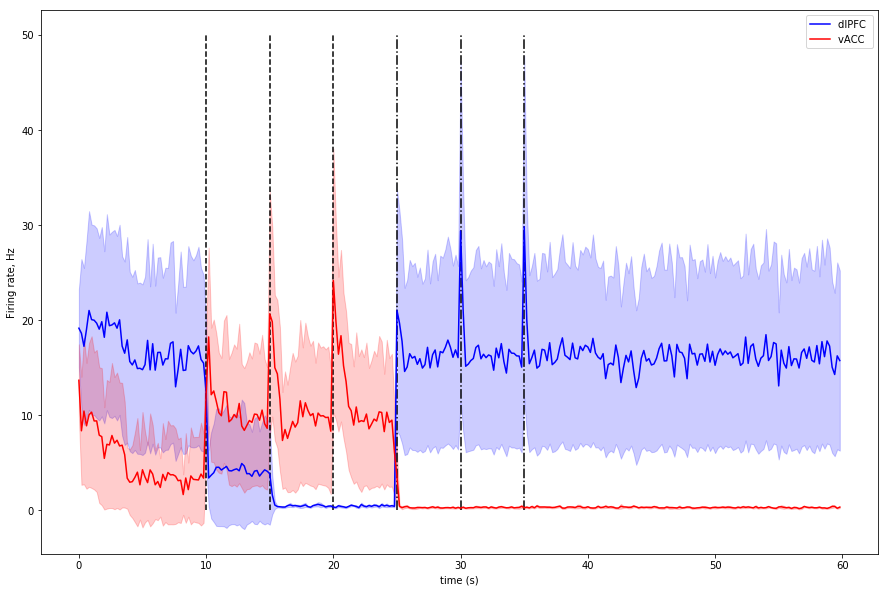

In [4]:


time = np.arange(0, 60,0.2)
plt.figure(figsize=(15,10))

healthy_8pA_Md_mean_rate = np.mean(Md_rate_healthy_8pA, axis = 0)
healthy_8pA_Mv_mean_rate = np.mean(Mv_rate_healthy_8pA, axis = 0)



healthy_8pA_Md_std_rate = np.std(Md_rate_healthy_8pA, axis = 0)
healthy_8pA_Mv_std_rate = np.std(Mv_rate_healthy_8pA, axis = 0)


y_upper_Mv = healthy_8pA_Mv_mean_rate + healthy_8pA_Mv_std_rate/2
y_lower_Mv = healthy_8pA_Mv_mean_rate - healthy_8pA_Mv_std_rate/2

y_upper_Md = healthy_8pA_Md_mean_rate + healthy_8pA_Md_std_rate/2
y_lower_Md = healthy_8pA_Md_mean_rate - healthy_8pA_Md_std_rate/2


plt.plot(time, healthy_8pA_Md_mean_rate, 'b-', label="dlPFC ")
plt.plot(time,healthy_8pA_Mv_mean_rate, 'r-', label="vACC ")
plt.vlines(10.0,0,50,linestyle = 'dashed')
plt.vlines(15.0,0,50,linestyle = 'dashed')
plt.vlines(20.0,0,50,linestyle = 'dashed')
plt.vlines(25.0,0,50,linestyle = 'dashdot')
plt.vlines(30.0,0,50,linestyle = 'dashdot')
plt.vlines(35.0,0,50,linestyle = 'dashdot')
plt.ylabel("Firing rate, Hz")
plt.xlabel("time (s)")

plt.fill_between(time,y_upper_Md, y_lower_Md,color='blue', alpha=0.2)
plt.fill_between(time,y_upper_Mv, y_lower_Mv,color='red', alpha=0.2)
plt.legend()
plt.savefig('Healthy with 8pA 10 trials')

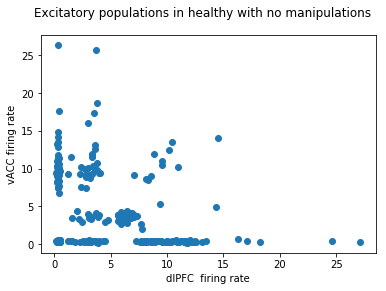

In [8]:
plt.scatter(Md_mean_healthy_clean,Mv_mean_healthy_clean)
plt.ylabel('vACC firing rate')
plt.xlabel('dlPFC  firing rate')
plt.suptitle('Excitatory populations in healthy with no manipulations')
plt.savefig('Healthy excitatory populations no manipulations over 10 runs ')


In [3]:
def Calc_mean_membran_potential_per_bin(Membrane_potential_monitor):
    Mean_potential_per_ms = []
    Mean_potential_per_bin = []
    
    for j in range(len(Membrane_potential_monitor.values[0])):
        Mean_potential_per_ms.append(statistics.mean(Membrane_potential_monitor.values[:,j]))
    
    for i in range(0,len(Mean_potential_per_ms),2000):
        Mean_potential_per_bin.append(statistics.mean(Mean_potential_per_ms[i:i+200]))
    
    return(Mean_potential_per_bin)

In [7]:
def Calc_mean_rate_per_bin(Md_rate_membrane):
    Mean_rate_per_ms = []
    Mean_rate_per_bin = []
    
    for j in range(150):
        Mean_rate_per_ms.append(statistics.mean(Md_rate_membrane[:,j]))
    
    for i in range(0,len(Mean_rate_per_ms),2000):
        Mean_rate_per_bin.append(statistics.mean(Mean_rate_per_ms[i:i+200]))
    
    return(Mean_rate_per_bin)

In [8]:
Mean_rate_per_bin_1pA = Calc_mean_rate_per_bin(Md_rate_membrane[0])
Mean_rate_per_bin_2pA = Calc_mean_rate_per_bin(Md_rate_membrane[1])
Mean_rate_per_bin_3pA = Calc_mean_rate_per_bin(Md_rate_membrane[2])
Mean_rate_per_bin_4pA = Calc_mean_rate_per_bin(Md_rate_membrane[3])
Mean_rate_per_bin_5pA = Calc_mean_rate_per_bin(Md_rate_membrane[4])
Mean_rate_per_bin_6pA = Calc_mean_rate_per_bin(Md_rate_membrane[5])
Mean_rate_per_bin_7pA = Calc_mean_rate_per_bin(Md_rate_membrane[6])
Mean_rate_per_bin_8pA = Calc_mean_rate_per_bin(Md_rate_membrane[7])
Mean_rate_per_bin_9pA = Calc_mean_rate_per_bin(Md_rate_membrane[8])
Mean_rate_per_bin_10pA = Calc_mean_rate_per_bin(Md_rate_membrane[9])

IndexError: too many indices for array

In [14]:
# Md_rate_membrane,
# Md_potential

# Mean_potential_per_bin_10pA = Calc_mean_membran_potential_per_bin(Membrane_potential_ed[0])
Mean_potential_per_bin_1pA = Calc_mean_membran_potential_per_bin(Md_potential[0])
Mean_potential_per_bin_2pA = Calc_mean_membran_potential_per_bin(Md_potential[1])
Mean_potential_per_bin_3pA = Calc_mean_membran_potential_per_bin(Md_potential[2])
Mean_potential_per_bin_4pA = Calc_mean_membran_potential_per_bin(Md_potential[3])
Mean_potential_per_bin_5pA = Calc_mean_membran_potential_per_bin(Md_potential[4])
Mean_potential_per_bin_6pA = Calc_mean_membran_potential_per_bin(Md_potential[5])
Mean_potential_per_bin_7pA = Calc_mean_membran_potential_per_bin(Md_potential[6])
Mean_potential_per_bin_8pA = Calc_mean_membran_potential_per_bin(Md_potential[7])
Mean_potential_per_bin_9pA = Calc_mean_membran_potential_per_bin(Md_potential[8])
Mean_potential_per_bin_10pA = Calc_mean_membran_potential_per_bin(Md_potential[9])

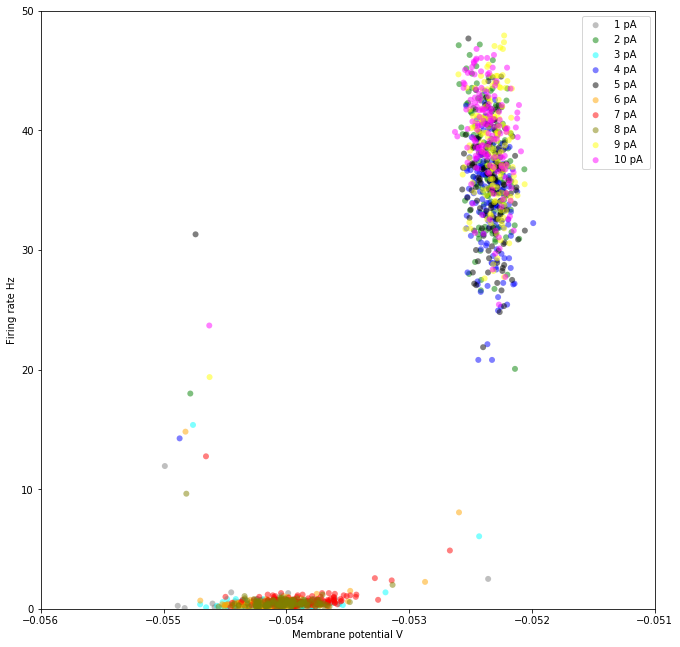

In [37]:
colour = ['blue','black','orange','green','magenta','red','yellow','brown','cyan','grey']
time = np.arange(0, 30,0.2)

fig = plt.figure(figsize=(11, 11))
ax = plt.subplot(111)

ax.scatter(Mean_potential_per_bin_1pA, Md_rate_membrane[0], c='grey', label = '1 pA ', alpha=0.5, edgecolors='none')
ax.scatter(Mean_potential_per_bin_2pA, Md_rate_membrane[1], c='green', label = '2 pA ', alpha=0.5, edgecolors='none')
ax.scatter(Mean_potential_per_bin_3pA, Md_rate_membrane[2], c='cyan', label = '3 pA ', alpha=0.5, edgecolors='none')
ax.scatter(Mean_potential_per_bin_4pA, Md_rate_membrane[3], c='blue', label = '4 pA ', alpha=0.5, edgecolors='none')
ax.scatter(Mean_potential_per_bin_5pA, Md_rate_membrane[4], c='black', label = '5 pA ',alpha=0.5, edgecolors='none')
ax.scatter(Mean_potential_per_bin_6pA, Md_rate_membrane[5], c='orange', label = '6 pA ',alpha=0.5, edgecolors='none')
ax.scatter(Mean_potential_per_bin_7pA, Md_rate_membrane[6], c='red', label = '7 pA ', alpha=0.5, edgecolors='none')

ax.scatter(Mean_potential_per_bin_8pA, Md_rate_membrane[7], c='olive', label = '8 pA ',alpha=0.5, edgecolors='none')

ax.scatter(Mean_potential_per_bin_9pA, Md_rate_membrane[8], c='yellow', label = '9 pA ',alpha=0.5, edgecolors='none')

ax.scatter(Mean_potential_per_bin_10pA, Md_rate_membrane[9], c='magenta', label = '10 pA ', alpha=0.5, edgecolors='none')
# ax.scatter(Mean_potential_per_bin_15pA, Mv_rate_15pA, c='magenta', label = '15 pA ',alpha=0.3, edgecolors='none')

ax.set_xlabel('Membrane potential V')
ax.set_ylabel('Firing rate Hz')
# ax.set_title(r' tDCS 10,9,15 pA')
ax.set_ylim([0, 50])
# ax.set_xlim([min(Mean_potential_per_bin_7pA), max(Mean_potential_per_bin_1pA)])
ax.set_xlim([-0.056, -0.051])

#plt.show()
plt.legend()
plt.title ('')

fig.savefig('varied tDCS 1-10.png')

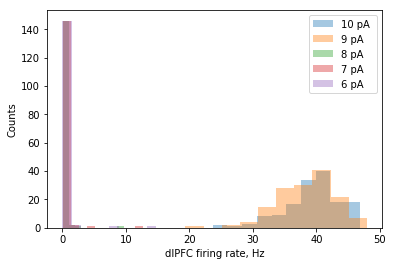

In [38]:
plt.hist(Md_rate_membrane[9],alpha=0.4,label = '10 pA ')
plt.hist(Md_rate_membrane[8],alpha=0.4,label = '9 pA ')
plt.hist(Md_rate_membrane[7],alpha=0.4,label = '8 pA ')
plt.hist(Md_rate_membrane[6],alpha=0.4,label = '7 pA ')
plt.hist(Md_rate_membrane[5],alpha=0.4,label = '6 pA ')
plt.legend()
plt.ylabel('Counts')
plt.xlabel('dlPFC firing rate, Hz')
plt.savefig('Histogram of firing under different currents')

Text(0.5,1,'')

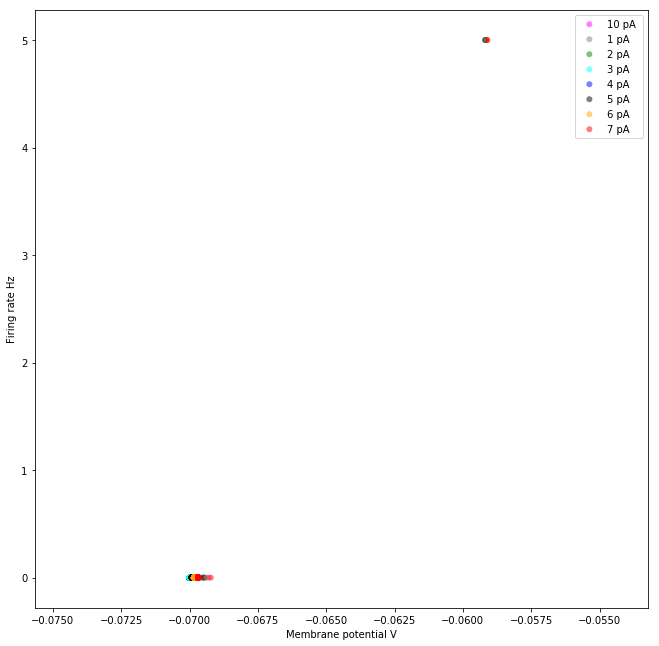

In [44]:
colour = ['blue','black','orange','green','magenta','red','yellow','brown','cyan','grey']
time = np.arange(0, 30,0.2)

fig = plt.figure(figsize=(11, 11))
ax = plt.subplot(111)
ax.scatter(Mean_potential_per_bin_10pA, Md_rate_membrane[9], c='magenta', label = '10 pA ', alpha=0.5, edgecolors='none')
ax.scatter(Mean_potential_per_bin_1pA, Md_rate_membrane[0], c='grey', label = '1 pA ', alpha=0.5, edgecolors='none')
ax.scatter(Mean_potential_per_bin_2pA, Md_rate_membrane[1], c='green', label = '2 pA ', alpha=0.5, edgecolors='none')
ax.scatter(Mean_potential_per_bin_3pA, Md_rate_membrane[2], c='cyan', label = '3 pA ', alpha=0.5, edgecolors='none')
ax.scatter(Mean_potential_per_bin_4pA, Md_rate_membrane[3], c='blue', label = '4 pA ', alpha=0.5, edgecolors='none')
ax.scatter(Mean_potential_per_bin_5pA, Md_rate_membrane[4], c='black', label = '5 pA ',alpha=0.5, edgecolors='none')
ax.scatter(Mean_potential_per_bin_6pA, Md_rate_membrane[5], c='orange', label = '6 pA ',alpha=0.5, edgecolors='none')
ax.scatter(Mean_potential_per_bin_7pA, Md_rate_membrane[6], c='red', label = '7 pA ', alpha=0.5, edgecolors='none')



# ax.scatter(Mean_potential_per_bin_5A, Mv_rate_5A, c='green', label = '5 pA ',alpha=0.5, edgecolors='none')
#ax.scatter(Mean_potential_per_bin_11A, Mv_rate_11A, c='red', label = '11 pA ',alpha=0.5, edgecolors='none')
#ax.scatter(Mean_potential_per_bin_15pA, Mv_rate_15pA, c='magenta', label = '15 pA ',alpha=0.3, edgecolors='none')

ax.set_xlabel('Membrane potential V')
ax.set_ylabel('Firing rate Hz')
# ax.set_title(r' tDCS 10,9,15 pA')
# ax.set_ylim([0, 50])
# ax.set_xlim([min(Mean_potential_per_bin_7pA), max(Mean_potential_per_bin_1pA)])
# ax.set_xlim([-0.0725, -0.0675])

#plt.show()
plt.legend()
plt.title ('')

# fig.savefig('varied tDCS 3-10.png')

In [ ]:
tdcs_current,Md_rate_healthy_varied_currents,Md_membrane_potential 

In [12]:
tdcs_current[0]

5.0 * pamp

In [22]:
Md_mean_per_t_per_current_red = []

for i in range (10):
    Md_mean_rate_per_t_per_current = np.mean(np.asarray(Md_rate_healthy_varied_currents)[i][:], axis = 0 )
    Md_mean_potential_per_t_per_current_re = np.mean(np.asarray(Md_membrane_potential)[i][:], axis = 0 )
    
    Md_mean_per_t_per_current_red.append(reduce_smpl(Md_mean_per_t_per_current))
    


IndexError: invalid index to scalar variable.

In [ ]:
Md_mean_per_t_per_current_1_re = reduce_smpl(np.mean(Md_membrane_potential [0][:], axis = 0 ))
Md_mean_per_t_per_current_2_re = reduce_smpl(np.mean(Md_membrane_potential [1][:], axis = 0 ))
Md_mean_per_t_per_current_3_re = reduce_smpl(np.mean(Md_membrane_potential [2][:], axis = 0 ))
Md_mean_per_t_per_current_4_re = reduce_smpl(np.mean(Md_membrane_potential [3][:], axis = 0 ))
Md_mean_per_t_per_current_5_re = reduce_smpl(np.mean(Md_membrane_potential [4][:], axis = 0 ))
Md_mean_per_t_per_current_6_re = reduce_smpl(np.mean(Md_membrane_potential [5][:], axis = 0 ))
Md_mean_per_t_per_current_7_re = reduce_smpl(np.mean(Md_membrane_potential [6][:], axis = 0 ))
Md_mean_per_t_per_current_8_re = reduce_smpl(np.mean(Md_membrane_potential [7][:], axis = 0 ))

In [5]:
Md_mean_per_t_per_current_1_re = reduce_smpl(np.mean(Md_membrane_potential [0][:], axis = 0 ))
Md_mean_per_t_per_current_2_re = reduce_smpl(np.mean(Md_membrane_potential [1][:], axis = 0 ))
Md_mean_per_t_per_current_3_re = reduce_smpl(np.mean(Md_membrane_potential [2][:], axis = 0 ))
Md_mean_per_t_per_current_4_re = reduce_smpl(np.mean(Md_membrane_potential [3][:], axis = 0 ))
Md_mean_per_t_per_current_5_re = reduce_smpl(np.mean(Md_membrane_potential [4][:], axis = 0 ))
Md_mean_per_t_per_current_6_re = reduce_smpl(np.mean(Md_membrane_potential [5][:], axis = 0 ))
Md_mean_per_t_per_current_7_re = reduce_smpl(np.mean(Md_membrane_potential [6][:], axis = 0 ))
Md_mean_per_t_per_current_8_re = reduce_smpl(np.mean(Md_membrane_potential [7][:], axis = 0 ))
Md_mean_per_t_per_current_9_re = reduce_smpl(np.mean(Md_membrane_potential[8][:], axis = 0 ))
Md_mean_per_t_per_current_10_re = reduce_smpl(np.mean(Md_membrane_potential[9][:], axis = 0 ))

In [13]:
tdcs_current

(5.0 * pamp,
 6.0 * pamp,
 8.0 * pamp,
 4.0 * pamp,
 0.0 * amp,
 3.0 * pamp,
 2.0 * pamp,
 7.0 * pamp,
 1.0 * pamp,
 9.0 * pamp)

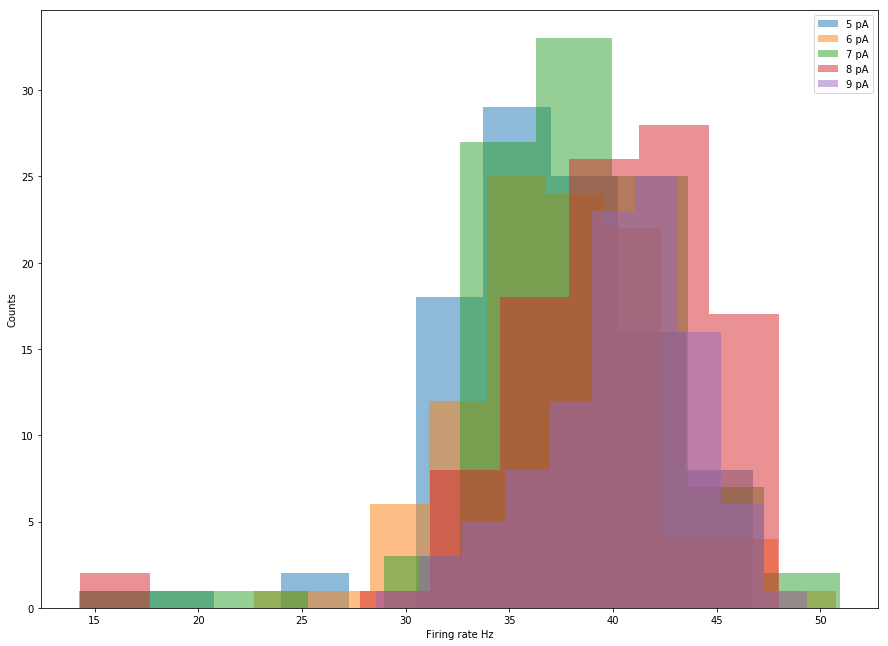

In [40]:

plt.figure(figsize=(15, 11))
# plt.hist(np.asarray(Md_rate_healthy_varied_currents[4]),alpha = 0.5, label = '0 pA')
# plt.hist(np.asarray(Md_rate_healthy_varied_currents[8]),alpha = 0.5, label = '1 pA')
# plt.hist(np.asarray(Md_rate_healthy_varied_currents[6]),alpha = 0.5, label = '2 pA')
# plt.hist(np.asarray(Md_rate_healthy_varied_currents[5]),alpha = 0.5, label = '3 pA')
# plt.hist(np.asarray(Md_rate_healthy_varied_currents[3]),alpha = 0.5, label = '4 pA')
plt.hist(np.asarray(Md_rate_healthy_varied_currents[0]),alpha = 0.5, label = '5 pA')
plt.hist(np.asarray(Md_rate_healthy_varied_currents[1]),alpha = 0.5, label = '6 pA')
plt.hist(np.asarray(Md_rate_healthy_varied_currents[7]),alpha = 0.5, label = '7 pA')
plt.hist(np.asarray(Md_rate_healthy_varied_currents[2]),alpha = 0.5, label = '8 pA')

plt.hist(np.asarray(Md_rate_healthy_varied_currents[9]),alpha = 0.5, label = '9 pA')
plt.xlabel('Firing rate Hz')
plt.ylabel('Counts')
plt.legend()
plt.savefig('distribution of rates with 5-9 pA')


In [4]:
def reduce_smpl(Mean_rate):
    
    step = np.arange(0,200000,2000)
    Md_reduced = []

    for i in step: 
        Md_reduced.append(Mean_rate[i])

    return(Md_reduced)



In [31]:
np.asarray(Md_mean_per_t_per_current_1_re).shape

(100,)

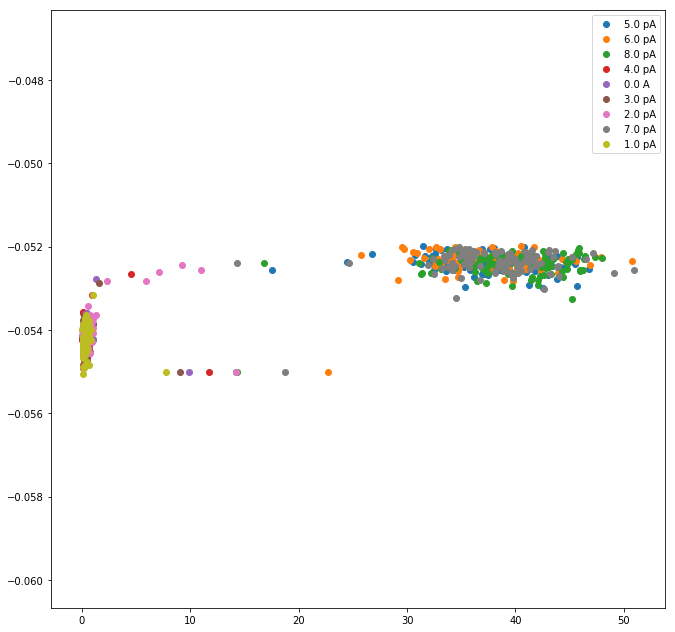

In [6]:
time = np.arange(0,20, 0.2)
plt.figure(figsize=(11, 11))

plt.scatter(Md_rate_healthy_varied_currents[0], Md_mean_per_t_per_current_1_re, label = tdcs_current[0])
plt.scatter(Md_rate_healthy_varied_currents[1], Md_mean_per_t_per_current_2_re, label =tdcs_current[1])
plt.scatter(Md_rate_healthy_varied_currents[2], Md_mean_per_t_per_current_3_re, label =tdcs_current[2] )
plt.scatter(Md_rate_healthy_varied_currents[3], Md_mean_per_t_per_current_4_re, label =tdcs_current[3] )
plt.scatter(Md_rate_healthy_varied_currents[4], Md_mean_per_t_per_current_5_re, label = tdcs_current[4])
plt.scatter(Md_rate_healthy_varied_currents[5], Md_mean_per_t_per_current_6_re, label = tdcs_current[5])
plt.scatter(Md_rate_healthy_varied_currents[6], Md_mean_per_t_per_current_7_re, label =tdcs_current[6])
plt.scatter(Md_rate_healthy_varied_currents[7], Md_mean_per_t_per_current_8_re, label =tdcs_current[7])
plt.scatter(Md_rate_healthy_varied_currents[8], Md_mean_per_t_per_current_9_re, label =tdcs_current[8])
plt.legend()

In [33]:
tdcs_current

(5.0 * pamp,
 6.0 * pamp,
 8.0 * pamp,
 4.0 * pamp,
 0.0 * amp,
 3.0 * pamp,
 2.0 * pamp,
 7.0 * pamp,
 1.0 * pamp,
 9.0 * pamp)

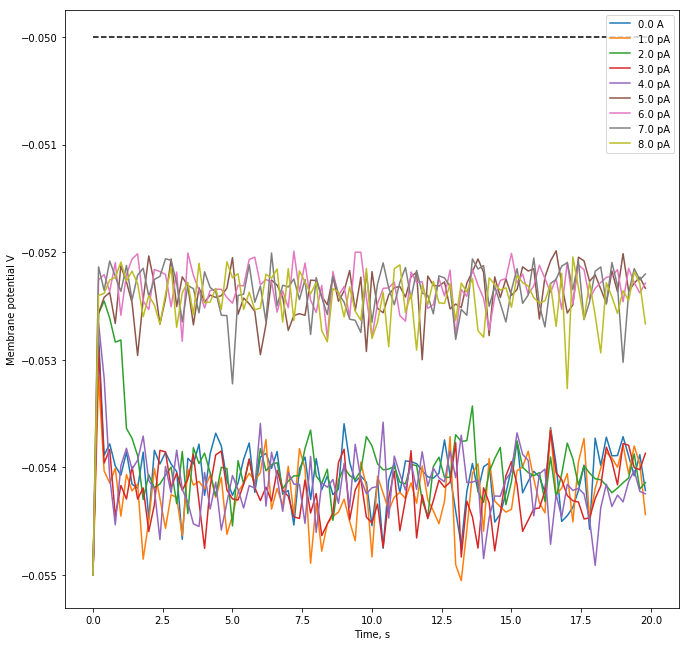

In [41]:
time = np.arange(0,20, 0.2)
plt.figure(figsize=(11, 11))
plt.hlines(-0.050,0,20,linestyle = 'dashed')
plt.plot(time, Md_mean_per_t_per_current_5_re, label = tdcs_current[4])#0pA
plt.plot(time, Md_mean_per_t_per_current_9_re, label =tdcs_current[8])#1pA
plt.plot(time, Md_mean_per_t_per_current_7_re, label =tdcs_current[6])#2pA
plt.plot(time, Md_mean_per_t_per_current_6_re, label = tdcs_current[5])#3pA
plt.plot(time, Md_mean_per_t_per_current_4_re, label =tdcs_current[3] )#4pA
plt.plot(time, Md_mean_per_t_per_current_1_re, label = tdcs_current[0]) #5pa
plt.plot(time, Md_mean_per_t_per_current_2_re, label =tdcs_current[1]) # 6pA
plt.plot(time, Md_mean_per_t_per_current_8_re, label =tdcs_current[7])#7pA
plt.plot(time, Md_mean_per_t_per_current_3_re, label =tdcs_current[2] ) #8pA




plt.ylabel('Membrane potential V')
plt.xlabel('Time, s')



plt.legend()
plt.savefig('membrane potential 0 - 8 ')